<a href="https://colab.research.google.com/github/oxanaRC/CE902/blob/main/Random_forest_test260721a.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

26.07.21
Joining property sales dataset with local schools data (number of secondary schools in radius of 6 km and disadvantage pupils score). 
Joining property sales data with historic (3 mnths) median prices per bedroom
RF on a subset of data (Colchester, Chelmsford, Ipswich, Bury St Edmunds, Cambridge, Tendering and Uttlesford areas for 12 months - Jan, Feb, Mar, Apr, May, June, Jul, Aug, Sep, Oct, Nov, Dec 2018) - comparing RMSE for predictions obtained from data with binary 'district' columns and without).
Removing outliers (sales prices >=1.5m, bedrooms >5, comparison with historic median>100%)






In [1]:
!pip install harperdb

In [2]:
import harperdb
import pandas as pd
import numpy as np
from pathlib import Path

In [3]:
url='https://ce901data-orc0770.harperdbcloud.com'
db=harperdb.HarperDB(url=url,
            username='myuser',
            password='abcdef',
            timeout=500)

In [4]:
db

Below data is extracted from the SQL database, however because of poor performance of the JOIN SQL operations, instead of relational SQL statements, the JOIN operations are performed in pandas DataFrames (according to https://pandas.pydata.org/pandas-docs/stable/user_guide/merging.html).


The data extraction from SQL tables in placed within the loop to avoid the database timeout issues.

This extracts property sales data.



In [5]:
list_of_dfs = {}
count=0
for mt in range(1, 11):
  for yr in range (2018,2019):
    year=yr
    month=mt
    count=count+1
    #sqlstring1='SELECT bedrooms.id, bedrooms.num_of_beds, propertypurchases.price_paid, propertypurchases.town, propertypurchases.district, propertypurchases.estate_type, propertypurchases.property_type, propertypurchases.deed_date '
    #sqlstring2='FROM projectdata.bedrooms LEFT OUTER JOIN projectdata.propertypurchases ON bedrooms.id=propertypurchases.unique_id WHERE (num_of_beds>0 and deed_date LIKE "%{}/{}")'
    #sqlstring2='FROM projectdata.bedrooms LEFT OUTER JOIN projectdata.propertypurchases ON bedrooms.id=propertypurchases.unique_id WHERE deed_date LIKE "%{}/{}"'
    #sqlstring=sqlstring1+sqlstring2
    sqlstring='SELECT propertypurchases.unique_id, propertypurchases.price_paid, propertypurchases.town, propertypurchases.district, propertypurchases.estate_type, propertypurchases.property_type, propertypurchases.deed_date, propertypurchases.postcode FROM projectdata.propertypurchases WHERE deed_date LIKE "%{}/{}"'
    sqlstring=sqlstring.format(month,year)
    print(sqlstring)
    my_db_data=db.sql(sqlstring)
    list_of_dfs[count] = pd.DataFrame(my_db_data)
    print(list_of_dfs[count].shape)
df_prop_sales = pd.concat(list_of_dfs, sort=False)
#excluding 'other' property types (i.e. commercial) from the properties sales data 
df_prop_sales=df_prop_sales[(df_prop_sales['property_type']!='O')]
df_prop_sales

SELECT propertypurchases.unique_id, propertypurchases.price_paid, propertypurchases.town, propertypurchases.district, propertypurchases.estate_type, propertypurchases.property_type, propertypurchases.deed_date, propertypurchases.postcode FROM projectdata.propertypurchases WHERE deed_date LIKE "%1/2018"
(169065, 8)
SELECT propertypurchases.unique_id, propertypurchases.price_paid, propertypurchases.town, propertypurchases.district, propertypurchases.estate_type, propertypurchases.property_type, propertypurchases.deed_date, propertypurchases.postcode FROM projectdata.propertypurchases WHERE deed_date LIKE "%2/2018"
(157760, 8)
SELECT propertypurchases.unique_id, propertypurchases.price_paid, propertypurchases.town, propertypurchases.district, propertypurchases.estate_type, propertypurchases.property_type, propertypurchases.deed_date, propertypurchases.postcode FROM projectdata.propertypurchases WHERE deed_date LIKE "%3/2018"
(84147, 8)
SELECT propertypurchases.unique_id, propertypurchases

unique_id  ...  postcode
1  0      64342BFD-ABA7-422C-E053-6C04A8C0FB8A  ...    E8 4NE
   1      64342BFD-ABAA-422C-E053-6C04A8C0FB8A  ...    N5 1BZ
   2      64342BFD-ABAB-422C-E053-6C04A8C0FB8A  ...   W11 1NZ
   3      64342BFD-ABAC-422C-E053-6C04A8C0FB8A  ...   IG3 9NB
   4      64342BFD-ABB0-422C-E053-6C04A8C0FB8A  ...   W12 8JN
...                                        ...  ...       ...
10 93062  C18F412B-1446-81A6-E053-6B04A8C0AD18  ...  CH42 2AQ
   93063  C18F412B-14DD-81A6-E053-6B04A8C0AD18  ...   L36 9TG
   93064  C18F412B-795D-81A6-E053-6B04A8C0AD18  ...   B31 2NA
   93065  C18F412B-94F2-81A6-E053-6B04A8C0AD18  ...   LS7 4AG
   93066  C18F412B-97A6-81A6-E053-6B04A8C0AD18  ...   E14 9XD

[964028 rows x 8 columns]

Below extracting number of bedrooms data for each property sale id.


In [6]:
sqlstring='SELECT bedrooms.id, bedrooms.num_of_beds FROM projectdata.bedrooms WHERE num_of_beds>0'
bedrooms=db.sql(sqlstring)
df_bedrooms=pd.DataFrame(bedrooms)
df_bedrooms.rename(columns = {'id':'unique_id'}, inplace = True)
df_bedrooms

,unique_id,num_of_beds
0,726BF13A-B9B6-0A46-E053-6C04A8C01D0D,1
1,726BF13B-13CE-0A46-E053-6C04A8C01D0D,1
2,79A74E21-DB3C-1289-E053-6B04A8C01627,1
3,79A74E21-1F11-1289-E053-6B04A8C01627,1
4,6B32222C-9C99-01F1-E053-6C04A8C0D2C8,1
...,...,...
596427,80E1AA98-910A-7BF8-E053-6C04A8C00BF2,23
596428,64342BFF-158B-422C-E053-6C04A8C0FB8A,23
596429,80E1AA98-773C-7BF8-E053-6C04A8C00BF2,32
596430,75050A86-10FB-9A88-E053-6B04A8C02390,46


In [7]:
#merging bedrooms data with property sales data.
data = pd.merge(df_bedrooms, df_prop_sales, how="left", on="unique_id")
data

,unique_id,num_of_beds,price_paid,town,district,estate_type,property_type,deed_date,postcode
0,726BF13A-B9B6-0A46-E053-6C04A8C01D0D,1,100000.0,MANCHESTER,SALFORD,L,T,20/07/2018,M30 8EG
1,726BF13B-13CE-0A46-E053-6C04A8C01D0D,1,128000.0,NORWICH,NORWICH,L,F,20/04/2018,NR3 1SX
2,79A74E21-DB3C-1289-E053-6B04A8C01627,1,33000.0,LIVERPOOL,LIVERPOOL,L,F,21/09/2018,L5 4TD
3,79A74E21-1F11-1289-E053-6B04A8C01627,1,405000.0,LONDON,HAMMERSMITH AND FULHAM,L,F,27/09/2018,W14 9BW
4,6B32222C-9C99-01F1-E053-6C04A8C0D2C8,1,156500.0,HAVERHILL,ST EDMUNDSBURY,F,T,29/03/2018,CB9 0EH
...,...,...,...,...,...,...,...,...,...
596427,80E1AA98-910A-7BF8-E053-6C04A8C00BF2,23,335000.0,SUTTON,SUTTON,F,S,19/12/2018,SM1 2EG
596428,64342BFF-158B-422C-E053-6C04A8C0FB8A,23,80000.0,WOLVERHAMPTON,WOLVERHAMPTON,F,T,12/01/2018,WV2 4NA
596429,80E1AA98-773C-7BF8-E053-6C04A8C00BF2,32,108000.0,NOTTINGHAM,CITY OF NOTTINGHAM,F,S,19/12/2018,NG8 3AA
596430,75050A86-10FB-9A88-E053-6B04A8C02390,46,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
#check rows where postcode is NAN - these are the result of rows added on the Join with bedrooms data where bedrooms data is for sale happened after the considered period
#data_t=data[ (data['postcode'].isnull()) ]
#drop NAN rows from data
data=data.dropna(subset=['postcode'])     
data 

,unique_id,num_of_beds,price_paid,town,district,estate_type,property_type,deed_date,postcode
0,726BF13A-B9B6-0A46-E053-6C04A8C01D0D,1,100000.0,MANCHESTER,SALFORD,L,T,20/07/2018,M30 8EG
1,726BF13B-13CE-0A46-E053-6C04A8C01D0D,1,128000.0,NORWICH,NORWICH,L,F,20/04/2018,NR3 1SX
2,79A74E21-DB3C-1289-E053-6B04A8C01627,1,33000.0,LIVERPOOL,LIVERPOOL,L,F,21/09/2018,L5 4TD
3,79A74E21-1F11-1289-E053-6B04A8C01627,1,405000.0,LONDON,HAMMERSMITH AND FULHAM,L,F,27/09/2018,W14 9BW
4,6B32222C-9C99-01F1-E053-6C04A8C0D2C8,1,156500.0,HAVERHILL,ST EDMUNDSBURY,F,T,29/03/2018,CB9 0EH
...,...,...,...,...,...,...,...,...,...
596426,80E1AA98-910A-7BF8-E053-6C04A8C00BF2,23,335000.0,SUTTON,SUTTON,F,S,19/12/2018,SM1 2EG
596427,80E1AA98-910A-7BF8-E053-6C04A8C00BF2,23,335000.0,SUTTON,SUTTON,F,S,19/12/2018,SM1 2EG
596428,64342BFF-158B-422C-E053-6C04A8C0FB8A,23,80000.0,WOLVERHAMPTON,WOLVERHAMPTON,F,T,12/01/2018,WV2 4NA
596429,80E1AA98-773C-7BF8-E053-6C04A8C00BF2,32,108000.0,NOTTINGHAM,CITY OF NOTTINGHAM,F,S,19/12/2018,NG8 3AA


In [9]:
#removing duplicates (some bedroom data was loaded twice by mistake)
data=data.drop_duplicates()
data

,unique_id,num_of_beds,price_paid,town,district,estate_type,property_type,deed_date,postcode
0,726BF13A-B9B6-0A46-E053-6C04A8C01D0D,1,100000.0,MANCHESTER,SALFORD,L,T,20/07/2018,M30 8EG
1,726BF13B-13CE-0A46-E053-6C04A8C01D0D,1,128000.0,NORWICH,NORWICH,L,F,20/04/2018,NR3 1SX
2,79A74E21-DB3C-1289-E053-6B04A8C01627,1,33000.0,LIVERPOOL,LIVERPOOL,L,F,21/09/2018,L5 4TD
3,79A74E21-1F11-1289-E053-6B04A8C01627,1,405000.0,LONDON,HAMMERSMITH AND FULHAM,L,F,27/09/2018,W14 9BW
4,6B32222C-9C99-01F1-E053-6C04A8C0D2C8,1,156500.0,HAVERHILL,ST EDMUNDSBURY,F,T,29/03/2018,CB9 0EH
...,...,...,...,...,...,...,...,...,...
596425,6B32222C-0F70-01F1-E053-6C04A8C0D2C8,17,140000.0,PONTYPOOL,TORFAEN,F,T,05/01/2018,NP4 6DA
596426,80E1AA98-910A-7BF8-E053-6C04A8C00BF2,23,335000.0,SUTTON,SUTTON,F,S,19/12/2018,SM1 2EG
596428,64342BFF-158B-422C-E053-6C04A8C0FB8A,23,80000.0,WOLVERHAMPTON,WOLVERHAMPTON,F,T,12/01/2018,WV2 4NA
596429,80E1AA98-773C-7BF8-E053-6C04A8C00BF2,32,108000.0,NOTTINGHAM,CITY OF NOTTINGHAM,F,S,19/12/2018,NG8 3AA


In [10]:
#Extracting sales-postcodes-mappings-to-schools-postcodes 
#Extraction of  sales-postcodes-mappings-to-schools-postcodes' has to be done in batches to prevent timeout issues 
list_of_dfs_sm = {}
my_range_a=0
count=0
for x in range(1, 20):
    my_range_b=x*10000
    my_range_a=my_range_b-10000
    count=count+1
    sqlstring='SELECT sales_pc_to_school_ps_map.sales_postcode,  sales_pc_to_school_ps_map.urn, sales_pc_to_school_ps_map.distance, sales_pc_to_school_ps_map.disadv_prct, sales_pc_to_school_ps_map.aver_attain_eng , sales_pc_to_school_ps_map.aver_attain_math FROM projectdata. sales_pc_to_school_ps_map  WHERE count_p >= {} and count_p <{}'
    sqlstring=sqlstring.format(my_range_a,my_range_b)
    print(sqlstring)
    my_db_data=db.sql(sqlstring)
    list_of_dfs_sm[count] = pd.DataFrame(my_db_data)
    print(list_of_dfs_sm[count].shape)
df_local_schools = pd.concat(list_of_dfs_sm, sort=False)
df_local_schools


SELECT sales_pc_to_school_ps_map.sales_postcode,  sales_pc_to_school_ps_map.urn, sales_pc_to_school_ps_map.distance, sales_pc_to_school_ps_map.disadv_prct, sales_pc_to_school_ps_map.aver_attain_eng , sales_pc_to_school_ps_map.aver_attain_math FROM projectdata. sales_pc_to_school_ps_map  WHERE count_p >= 0 and count_p <10000
(727849, 6)
SELECT sales_pc_to_school_ps_map.sales_postcode,  sales_pc_to_school_ps_map.urn, sales_pc_to_school_ps_map.distance, sales_pc_to_school_ps_map.disadv_prct, sales_pc_to_school_ps_map.aver_attain_eng , sales_pc_to_school_ps_map.aver_attain_math FROM projectdata. sales_pc_to_school_ps_map  WHERE count_p >= 10000 and count_p <20000
(557163, 6)
SELECT sales_pc_to_school_ps_map.sales_postcode,  sales_pc_to_school_ps_map.urn, sales_pc_to_school_ps_map.distance, sales_pc_to_school_ps_map.disadv_prct, sales_pc_to_school_ps_map.aver_attain_eng , sales_pc_to_school_ps_map.aver_attain_math FROM projectdata. sales_pc_to_school_ps_map  WHERE count_p >= 20000 and count

sales_postcode       urn  ...  aver_attain_eng aver_attain_math
1  0           LL13 9QX       0.0  ...              0.0              0.0
   1           RH13 8BH       0.0  ...              0.0              0.0
   2            M27 9UR  138418.0  ...              6.7              6.0
   3            M27 9UR  131512.0  ...              9.7              9.3
   4            M27 9UR  143059.0  ...              7.9              7.1
...                 ...       ...  ...              ...              ...
17 38165        BL7 9HU  144044.0  ...             11.3             10.8
   38166        BL7 9HU  145314.0  ...              6.9              6.4
   38167        BL7 9HU  141941.0  ...              7.6              7.4
   38168        BL7 9HU  142340.0  ...             12.8             10.8
   38169        BL7 9HU  105253.0  ...             10.3              8.8

[4271081 rows x 6 columns]

In [11]:
#the school data contains special schools
data_test = df_local_schools[(df_local_schools['disadv_prct']=='NP')]
data_test


sales_postcode       urn  ...  aver_attain_eng aver_attain_math
1  67           SK4 2HZ  134064.0  ...              0.6              1.8
   935         BH14 9HQ  113954.0  ...              0.3              1.1
   1099        BH12 2HU  113954.0  ...              0.3              1.1
   1543         SK2 6ES  134064.0  ...              0.6              1.8
   1914         L17 3BB  104734.0  ...              0.7              0.9
...                 ...       ...  ...              ...              ...
17 36582        BH9 1HJ  113954.0  ...              0.3              1.1
   36804       DE22 2JH  113044.0  ...              1.4              1.0
   36910       BH14 8PY  113954.0  ...              0.3              1.1
   37907       RG14 7SF  110180.0  ...              5.3              6.2
   37956        SK4 4ED  134064.0  ...              0.6              1.8

[16870 rows x 6 columns]

In [12]:
#These two postcodes have to be excluded from the data as these only have special scools in the radius of 6km and, when dropping the special schools from the data, these postcodes do not have any records in the school mapping
data_test1 = data_test[(data_test['sales_postcode'] =='OX15 5SA') | (data_test['sales_postcode'] =='TN8 6JQ' ) ]
data_test1

,,sales_postcode,urn,distance,disadv_prct,aver_attain_eng,aver_attain_math
1,56667,OX15 5SA,123331.0,2.539054,NP,2.9,4.7
7,110646,TN8 6JQ,125454.0,5.526534,NP,4.1,2.1


In [13]:
#remove special schools 
df_local_schools.drop(df_local_schools[df_local_schools['disadv_prct']=='NP'].index, inplace = True)
df_local_schools

sales_postcode       urn  ...  aver_attain_eng aver_attain_math
1  0           LL13 9QX       0.0  ...              0.0              0.0
   1           RH13 8BH       0.0  ...              0.0              0.0
   2            M27 9UR  138418.0  ...              6.7              6.0
   3            M27 9UR  131512.0  ...              9.7              9.3
   4            M27 9UR  143059.0  ...              7.9              7.1
...                 ...       ...  ...              ...              ...
17 38165        BL7 9HU  144044.0  ...             11.3             10.8
   38166        BL7 9HU  145314.0  ...              6.9              6.4
   38167        BL7 9HU  141941.0  ...              7.6              7.4
   38168        BL7 9HU  142340.0  ...             12.8             10.8
   38169        BL7 9HU  105253.0  ...             10.3              8.8

[4254211 rows x 6 columns]

In [14]:
#cheking if the school mappings data contains Nan
data_test = df_local_schools[(df_local_schools['disadv_prct'].isnull())]
data_test

,,sales_postcode,urn,distance,disadv_prct,aver_attain_eng,aver_attain_math


In [15]:
#cheking if the school mappings data contains duplicates
school_map_dupl = df_local_schools[df_local_schools.duplicated()]
school_map_dupl

,,sales_postcode,urn,distance,disadv_prct,aver_attain_eng,aver_attain_math


In [16]:
#check data for a specific sales postcode
data_test4 = df_local_schools[(df_local_schools['sales_postcode'] =='B13 8PG') ]
data_test4

sales_postcode       urn  ...  aver_attain_eng aver_attain_math
7 196205        B13 8PG  141003.0  ...              9.3              6.9
  196206        B13 8PG  138200.0  ...              8.2              5.4
  196207        B13 8PG  136944.0  ...             12.3              9.6
  196208        B13 8PG  130461.0  ...              1.4              2.3
  196209        B13 8PG  138222.0  ...              7.6              8.1
  196210        B13 8PG  103493.0  ...             10.6              8.8
  196211        B13 8PG  103538.0  ...              9.5              7.9
  196212        B13 8PG  144464.0  ...              9.5              9.0
  196213        B13 8PG  140014.0  ...             11.1              7.7
  196214        B13 8PG  139994.0  ...             10.5              9.2
  196215        B13 8PG  135970.0  ...             11.1              8.9
  196216        B13 8PG  103486.0  ...              9.5              8.8
  196217        B13 8PG  103501.0  ...             10.5             10.0
  196218        B13 8PG  103514.0  ...             10.2              8.6
  196219        B13 8PG  103497.0  ...             11.1              9.7
  196220        B13 8PG  103519.0  ...              8.2              7.5
  196221        B13 8PG  103560.0  ...             12.4             10.6
  196222        B13 8PG  137044.0  ...             16.2             15.1
  196223        B13 8PG  137045.0  ...             15.5             17.0
  196224        B13 8PG  139797.0  ...              7.2              5.5
  196225        B13 8PG  136213.0  ...              9.2              7.8
  196226        B13 8PG  138695.0  ...              9.0              8.2
  196227        B13 8PG  103531.0  ...             12.4             11.3
  196228        B13 8PG  145120.0  ...              8.4              8.1
  196229        B13 8PG  136592.0  ...             12.2              9.1
  196230        B13 8PG  103606.0  ...              0.7              0.9
  196231        B13 8PG  136406.0  ...              9.7              8.5
  196232        B13 8PG  103541.0  ...              9.1              7.9
  196233        B13 8PG  137858.0  ...             10.2              8.6
  196234        B13 8PG  135911.0  ...              9.1              8.0
  196235        B13 8PG  103613.0  ...              0.1              0.3
  196236        B13 8PG  103498.0  ...             10.7              8.1
  196237        B13 8PG  103562.0  ...             10.6              9.8
  196238        B13 8PG  136590.0  ...             12.4              9.9
  196239        B13 8PG  141318.0  ...              8.7              7.3
  196240        B13 8PG  143438.0  ...             10.6              9.7
  196241        B13 8PG  103632.0  ...              1.8              1.3
  196242        B13 8PG  103499.0  ...              9.6              8.1
  196243        B13 8PG  137346.0  ...             11.5              9.3
  196244        B13 8PG  141835.0  ...             10.7              9.0
  196245        B13 8PG  137578.0  ...              9.7              8.0
  196246        B13 8PG  136924.0  ...             10.3              9.2

[42 rows x 6 columns]

In [17]:
#adding 'weights' to the school mapping data: calculated as 6km minus the distance from the sale postcode to a school
#the closer a school to the postocode, the greater the weight of that school
df_local_schools['weight']=6-df_local_schools['distance']
df_local_schools['disadv_prct']=df_local_schools['disadv_prct'].str.replace('%','')
df_local_schools['disadv_prct'] = df_local_schools['disadv_prct'].replace(np.nan, 0)  #fillna(0)
df_local_schools['disadv_prct'] = df_local_schools['disadv_prct']. fillna(0)
df_local_schools['disadv_prct']= pd.to_numeric(df_local_schools['disadv_prct'], downcast='float')
df_local_schools

sales_postcode       urn  ...  aver_attain_math    weight
1  0           LL13 9QX       0.0  ...               0.0  6.000000
   1           RH13 8BH       0.0  ...               0.0  6.000000
   2            M27 9UR  138418.0  ...               6.0  0.580426
   3            M27 9UR  131512.0  ...               9.3  2.112568
   4            M27 9UR  143059.0  ...               7.1  1.813905
...                 ...       ...  ...               ...       ...
17 38165        BL7 9HU  144044.0  ...              10.8  3.681288
   38166        BL7 9HU  145314.0  ...               6.4  1.960444
   38167        BL7 9HU  141941.0  ...               7.4  0.804329
   38168        BL7 9HU  142340.0  ...              10.8  0.017824
   38169        BL7 9HU  105253.0  ...               8.8  4.788904

[4254211 rows x 7 columns]

In [18]:
#calculating a score for each school mapping
df_local_schools['score_disadv']=df_local_schools['weight'].astype(float)*df_local_schools['disadv_prct'].astype(float)
df_local_schools

sales_postcode       urn  ...    weight  score_disadv
1  0           LL13 9QX       0.0  ...  6.000000      0.000000
   1           RH13 8BH       0.0  ...  6.000000      0.000000
   2            M27 9UR  138418.0  ...  0.580426     35.406015
   3            M27 9UR  131512.0  ...  2.112568    111.966088
   4            M27 9UR  143059.0  ...  1.813905     83.439647
...                 ...       ...  ...       ...           ...
17 38165        BL7 9HU  144044.0  ...  3.681288     40.494167
   38166        BL7 9HU  145314.0  ...  1.960444     92.140848
   38167        BL7 9HU  141941.0  ...  0.804329     43.433767
   38168        BL7 9HU  142340.0  ...  0.017824      0.516892
   38169        BL7 9HU  105253.0  ...  4.788904     76.622469

[4254211 rows x 8 columns]

In [19]:
#counting number of secondary schools (in the radius of 6 km) for each sales postcode
g_sch_num = df_local_schools.groupby(['sales_postcode'])['urn'].count().reset_index()
g_sch_num.rename(columns = {'urn':'num_of_sec_sch'}, inplace = True)
g_sch_num.rename(columns = {'sales_postcode':'postcode'}, inplace = True)
g_sch_num

,postcode,num_of_sec_sch
0,AL1 1AJ,10
1,AL1 1AR,10
2,AL1 1AT,10
3,AL1 1AU,10
4,AL1 1DU,12
...,...,...
383258,YO8 9XH,3
383259,YO8 9XJ,3
383260,YO8 9XN,3
383261,YO8 9XP,3


In [20]:
#calculating average weighted disability score for each postcode
g_aver_score_disadv = df_local_schools.groupby(['sales_postcode'])['score_disadv'].mean().reset_index()
g_aver_score_disadv.rename(columns = {'sales_postcode':'postcode'}, inplace = True)
g_aver_score_disadv

,postcode,score_disadv
0,AL1 1AJ,78.575432
1,AL1 1AR,70.273088
2,AL1 1AT,73.883530
3,AL1 1AU,73.144251
4,AL1 1DU,45.623400
...,...,...
383258,YO8 9XH,69.623950
383259,YO8 9XJ,69.714311
383260,YO8 9XN,69.052363
383261,YO8 9XP,72.104548


In [21]:
#For calculating English and Math attainment score for each postcode we'll only consider the most closest school 
#(as taking average score value for all local schools will not be helpful - for example if one closest school in a rural area is 5.9 km away from a property - the distance weighting will diminish the score value)
#extracting the closest schools:
g_closest_schools = df_local_schools.groupby(['sales_postcode'])['distance'].min().reset_index()
g_closest_schools.rename(columns = {'distance':'closest_sch_distance'}, inplace = True)
g_closest_schools

,sales_postcode,closest_sch_distance
0,AL1 1AJ,0.932290
1,AL1 1AR,0.455425
2,AL1 1AT,0.676792
3,AL1 1AU,0.638617
4,AL1 1DU,0.913302
...,...,...
383258,YO8 9XH,0.665555
383259,YO8 9XJ,0.629437
383260,YO8 9XN,0.742595
383261,YO8 9XP,0.700789


In [22]:
#joining the closest school table with df_local_schools to obtains english and math attainment for the closest schools
g_closest_schools_with_data = pd.merge(df_local_schools, g_closest_schools, how="left", on="sales_postcode")
g_closest_schools_with_data.drop(g_closest_schools_with_data[g_closest_schools_with_data['distance']!=g_closest_schools_with_data['closest_sch_distance']].index, inplace = True)
g_closest_schools_with_data.rename(columns = {'disadv_prct':'closest_disadv_prct'}, inplace = True)
g_closest_schools_with_data.rename(columns = {'sales_postcode':'postcode'}, inplace = True)
g_closest_schools_with_data.rename(columns = {'aver_attain_eng':'closest_aver_attain_eng'}, inplace = True)
g_closest_schools_with_data.rename(columns = {'aver_attain_math':'closest_aver_attain_math'}, inplace = True)
g_closest_schools_with_data=g_closest_schools_with_data.drop(['distance', 'weight', 'score_disadv'], axis=1)
g_closest_schools_with_data

,postcode,urn,closest_disadv_prct,closest_aver_attain_eng,closest_aver_attain_math,closest_sch_distance
0,LL13 9QX,0.0,0.0,0.0,0.0,0.000000
1,RH13 8BH,0.0,0.0,0.0,0.0,0.000000
11,B63 1BZ,136618.0,32.0,10.3,9.4,1.336751
24,DE5 8JP,141259.0,35.0,9.9,9.7,1.795545
35,M27 9UR,105989.0,24.0,8.9,8.8,0.498811
...,...,...,...,...,...,...
4254144,NG34 0NG,0.0,0.0,0.0,0.0,0.000000
4254158,B33 0NL,144306.0,56.0,7.1,7.1,0.869836
4254176,LS29 7LF,136905.0,8.0,11.9,11.1,3.861065
4254186,M35 9LA,144627.0,35.0,8.5,7.9,0.442107


In [23]:
#some postcodes will have more than one school at exactly the same closest distance 
data_test2 = g_closest_schools_with_data.groupby(['postcode'])['urn'].count().reset_index()
data_test3=data_test2[(data_test2['urn'] !=1)]
data_test3

,postcode,urn
2090,B13 8PG,2
2091,B13 8PP,2
2092,B13 8PQ,2
2343,B14 6AB,2
2345,B14 6AH,2
...,...,...
378523,WV6 8LQ,2
378535,WV6 8PJ,2
378536,WV6 8PP,2
378537,WV6 8PQ,2


In [24]:
#chosing maximum closest_disadv_prct,	closest_aver_attain_eng,	closest_aver_attain_math for each sales postcode
g_closest_schools_max1 = g_closest_schools_with_data.groupby(['postcode'])['closest_disadv_prct'].max().reset_index()
g_closest_schools_max2 = g_closest_schools_with_data.groupby(['postcode'])['closest_aver_attain_eng'].max().reset_index()
g_closest_schools_max3 = g_closest_schools_with_data.groupby(['postcode'])['closest_aver_attain_math'].max().reset_index()
g_closest_schools_max4 = g_closest_schools_with_data.groupby(['postcode'])['closest_sch_distance'].max().reset_index()
g_closest_schools_with_data_max=pd.merge(g_closest_schools_max1,g_closest_schools_max2, how="left", on="postcode")
g_closest_schools_with_data_max=pd.merge(g_closest_schools_with_data_max,g_closest_schools_max3, how="left", on="postcode")
g_closest_schools_with_data_max=pd.merge(g_closest_schools_with_data_max,g_closest_schools_max4, how="left", on="postcode")
g_closest_schools_with_data_max

,postcode,closest_disadv_prct,closest_aver_attain_eng,closest_aver_attain_math,closest_sch_distance
0,AL1 1AJ,10.0,12.3,10.8,0.932290
1,AL1 1AR,25.0,10.6,9.2,0.455425
2,AL1 1AT,25.0,10.6,9.2,0.676792
3,AL1 1AU,25.0,10.6,9.2,0.638617
4,AL1 1DU,25.0,10.6,9.2,0.913302
...,...,...,...,...,...
383258,YO8 9XH,18.0,9.6,10.1,0.665555
383259,YO8 9XJ,18.0,9.6,10.1,0.629437
383260,YO8 9XN,18.0,9.6,10.1,0.742595
383261,YO8 9XP,18.0,9.6,10.1,0.700789


In [25]:
#join all school data together
#for each prop sales postcode we have number of secondary schools in radius 6 km, weighted average disadvantage score, closest school disadv %, closest sch eng and math attaint, closest sch distance
#alltogether 6 features related to schools data
prepared_sch_data = pd.merge(g_sch_num, g_aver_score_disadv, how="left", on="postcode")
prepared_sch_data = pd.merge(prepared_sch_data, g_closest_schools_with_data_max, how="left", on="postcode")
prepared_sch_data

,postcode,num_of_sec_sch,score_disadv,closest_disadv_prct,closest_aver_attain_eng,closest_aver_attain_math,closest_sch_distance
0,AL1 1AJ,10,78.575432,10.0,12.3,10.8,0.932290
1,AL1 1AR,10,70.273088,25.0,10.6,9.2,0.455425
2,AL1 1AT,10,73.883530,25.0,10.6,9.2,0.676792
3,AL1 1AU,10,73.144251,25.0,10.6,9.2,0.638617
4,AL1 1DU,12,45.623400,25.0,10.6,9.2,0.913302
...,...,...,...,...,...,...,...
383258,YO8 9XH,3,69.623950,18.0,9.6,10.1,0.665555
383259,YO8 9XJ,3,69.714311,18.0,9.6,10.1,0.629437
383260,YO8 9XN,3,69.052363,18.0,9.6,10.1,0.742595
383261,YO8 9XP,3,72.104548,18.0,9.6,10.1,0.700789


In [26]:
data

,unique_id,num_of_beds,price_paid,town,district,estate_type,property_type,deed_date,postcode
0,726BF13A-B9B6-0A46-E053-6C04A8C01D0D,1,100000.0,MANCHESTER,SALFORD,L,T,20/07/2018,M30 8EG
1,726BF13B-13CE-0A46-E053-6C04A8C01D0D,1,128000.0,NORWICH,NORWICH,L,F,20/04/2018,NR3 1SX
2,79A74E21-DB3C-1289-E053-6B04A8C01627,1,33000.0,LIVERPOOL,LIVERPOOL,L,F,21/09/2018,L5 4TD
3,79A74E21-1F11-1289-E053-6B04A8C01627,1,405000.0,LONDON,HAMMERSMITH AND FULHAM,L,F,27/09/2018,W14 9BW
4,6B32222C-9C99-01F1-E053-6C04A8C0D2C8,1,156500.0,HAVERHILL,ST EDMUNDSBURY,F,T,29/03/2018,CB9 0EH
...,...,...,...,...,...,...,...,...,...
596425,6B32222C-0F70-01F1-E053-6C04A8C0D2C8,17,140000.0,PONTYPOOL,TORFAEN,F,T,05/01/2018,NP4 6DA
596426,80E1AA98-910A-7BF8-E053-6C04A8C00BF2,23,335000.0,SUTTON,SUTTON,F,S,19/12/2018,SM1 2EG
596428,64342BFF-158B-422C-E053-6C04A8C0FB8A,23,80000.0,WOLVERHAMPTON,WOLVERHAMPTON,F,T,12/01/2018,WV2 4NA
596429,80E1AA98-773C-7BF8-E053-6C04A8C00BF2,32,108000.0,NOTTINGHAM,CITY OF NOTTINGHAM,F,S,19/12/2018,NG8 3AA


In [27]:
#append prepared_sch_data to data
data = pd.merge(data, prepared_sch_data, how="left", on="postcode")
data

,unique_id,num_of_beds,price_paid,town,district,estate_type,property_type,deed_date,postcode,num_of_sec_sch,score_disadv,closest_disadv_prct,closest_aver_attain_eng,closest_aver_attain_math,closest_sch_distance
0,726BF13A-B9B6-0A46-E053-6C04A8C01D0D,1,100000.0,MANCHESTER,SALFORD,L,T,20/07/2018,M30 8EG,23.0,110.178111,96.0,0.5,0.9,0.671216
1,726BF13B-13CE-0A46-E053-6C04A8C01D0D,1,128000.0,NORWICH,NORWICH,L,F,20/04/2018,NR3 1SX,12.0,85.979811,20.0,11.5,9.8,0.584296
2,79A74E21-DB3C-1289-E053-6B04A8C01627,1,33000.0,LIVERPOOL,LIVERPOOL,L,F,21/09/2018,L5 4TD,34.0,94.537513,63.0,8.1,7.7,0.458854
3,79A74E21-1F11-1289-E053-6B04A8C01627,1,405000.0,LONDON,HAMMERSMITH AND FULHAM,L,F,27/09/2018,W14 9BW,48.0,92.003091,12.0,13.8,12.2,0.583012
4,6B32222C-9C99-01F1-E053-6C04A8C0D2C8,1,156500.0,HAVERHILL,ST EDMUNDSBURY,F,T,29/03/2018,CB9 0EH,3.0,129.724751,15.0,9.3,8.9,0.682354
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
584193,6B32222C-0F70-01F1-E053-6C04A8C0D2C8,17,140000.0,PONTYPOOL,TORFAEN,F,T,05/01/2018,NP4 6DA,1.0,0.000000,0.0,0.0,0.0,0.000000
584194,80E1AA98-910A-7BF8-E053-6C04A8C00BF2,23,335000.0,SUTTON,SUTTON,F,S,19/12/2018,SM1 2EG,27.0,45.826636,12.0,11.0,10.5,1.001365
584195,64342BFF-158B-422C-E053-6C04A8C0FB8A,23,80000.0,WOLVERHAMPTON,WOLVERHAMPTON,F,T,12/01/2018,WV2 4NA,25.0,81.207251,14.0,9.9,10.1,0.657090
584196,80E1AA98-773C-7BF8-E053-6C04A8C00BF2,32,108000.0,NOTTINGHAM,CITY OF NOTTINGHAM,F,S,19/12/2018,NG8 3AA,19.0,127.182512,59.0,7.5,6.5,0.325385


In [28]:
#checking where num_of_sec_sch is NAN 
data_nan_sch = data[(data['num_of_sec_sch'].isnull())]
data_nan_sch

,unique_id,num_of_beds,price_paid,town,district,estate_type,property_type,deed_date,postcode,num_of_sec_sch,score_disadv,closest_disadv_prct,closest_aver_attain_eng,closest_aver_attain_math,closest_sch_distance
21952,6B32222C-8D7F-01F1-E053-6C04A8C0D2C8,2,220000.0,BANBURY,CHERWELL,F,S,10/04/2018,OX15 5SA,NaN,NaN,NaN,NaN,NaN,NaN
36425,80E1AA98-36C5-7BF8-E053-6C04A8C00BF2,2,244000.0,EDENBRIDGE,SEVENOAKS,L,F,15/11/2018,TN8 6JQ,NaN,NaN,NaN,NaN,NaN,NaN
53519,79A74E22-00DD-1289-E053-6B04A8C01627,2,222500.0,BANBURY,CHERWELL,F,T,28/09/2018,OX15 5LF,NaN,NaN,NaN,NaN,NaN,NaN
66874,68FEB20B-9505-38DA-E053-6C04A8C051AE,2,152500.0,EDENBRIDGE,SEVENOAKS,L,T,09/02/2018,TN8 6GH,NaN,NaN,NaN,NaN,NaN,NaN
76995,773788C3-08A0-2CE4-E053-6C04A8C05E57,2,258700.0,BANBURY,CHERWELL,F,T,24/08/2018,OX15 5QQ,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564739,7E86B6FB-32C9-458C-E053-6B04A8C0C84C,5,467500.0,BANBURY,CHERWELL,F,D,16/11/2018,OX15 6NF,NaN,NaN,NaN,NaN,NaN,NaN
564878,75050A85-3818-9A88-E053-6B04A8C02390,5,525000.0,EDENBRIDGE,SEVENOAKS,F,D,15/08/2018,TN8 6JF,NaN,NaN,NaN,NaN,NaN,NaN
564939,773788C3-096B-2CE4-E053-6C04A8C05E57,5,363000.0,BANBURY,CHERWELL,F,S,26/07/2018,OX15 5PB,NaN,NaN,NaN,NaN,NaN,NaN
574759,773788C2-C1E8-2CE4-E053-6C04A8C05E57,5,538000.0,EDENBRIDGE,SEVENOAKS,F,D,10/09/2018,TN8 6GB,NaN,NaN,NaN,NaN,NaN,NaN


In [29]:
data = data.dropna()
data

,unique_id,num_of_beds,price_paid,town,district,estate_type,property_type,deed_date,postcode,num_of_sec_sch,score_disadv,closest_disadv_prct,closest_aver_attain_eng,closest_aver_attain_math,closest_sch_distance
0,726BF13A-B9B6-0A46-E053-6C04A8C01D0D,1,100000.0,MANCHESTER,SALFORD,L,T,20/07/2018,M30 8EG,23.0,110.178111,96.0,0.5,0.9,0.671216
1,726BF13B-13CE-0A46-E053-6C04A8C01D0D,1,128000.0,NORWICH,NORWICH,L,F,20/04/2018,NR3 1SX,12.0,85.979811,20.0,11.5,9.8,0.584296
2,79A74E21-DB3C-1289-E053-6B04A8C01627,1,33000.0,LIVERPOOL,LIVERPOOL,L,F,21/09/2018,L5 4TD,34.0,94.537513,63.0,8.1,7.7,0.458854
3,79A74E21-1F11-1289-E053-6B04A8C01627,1,405000.0,LONDON,HAMMERSMITH AND FULHAM,L,F,27/09/2018,W14 9BW,48.0,92.003091,12.0,13.8,12.2,0.583012
4,6B32222C-9C99-01F1-E053-6C04A8C0D2C8,1,156500.0,HAVERHILL,ST EDMUNDSBURY,F,T,29/03/2018,CB9 0EH,3.0,129.724751,15.0,9.3,8.9,0.682354
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
584193,6B32222C-0F70-01F1-E053-6C04A8C0D2C8,17,140000.0,PONTYPOOL,TORFAEN,F,T,05/01/2018,NP4 6DA,1.0,0.000000,0.0,0.0,0.0,0.000000
584194,80E1AA98-910A-7BF8-E053-6C04A8C00BF2,23,335000.0,SUTTON,SUTTON,F,S,19/12/2018,SM1 2EG,27.0,45.826636,12.0,11.0,10.5,1.001365
584195,64342BFF-158B-422C-E053-6C04A8C0FB8A,23,80000.0,WOLVERHAMPTON,WOLVERHAMPTON,F,T,12/01/2018,WV2 4NA,25.0,81.207251,14.0,9.9,10.1,0.657090
584196,80E1AA98-773C-7BF8-E053-6C04A8C00BF2,32,108000.0,NOTTINGHAM,CITY OF NOTTINGHAM,F,S,19/12/2018,NG8 3AA,19.0,127.182512,59.0,7.5,6.5,0.325385


In [30]:
#column to represent historic point: 01-2018=>1, 02-2018=>2 etc
#hist_mnth=12*(year-2018)+month
data['hist_mnth']=data['deed_date'].str.split('/').str[1].astype(int)+ 12*(data['deed_date'].str.split('/').str[2].astype(int)-2018)
data

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,unique_id,num_of_beds,price_paid,town,district,estate_type,property_type,deed_date,postcode,num_of_sec_sch,score_disadv,closest_disadv_prct,closest_aver_attain_eng,closest_aver_attain_math,closest_sch_distance,hist_mnth
0,726BF13A-B9B6-0A46-E053-6C04A8C01D0D,1,100000.0,MANCHESTER,SALFORD,L,T,20/07/2018,M30 8EG,23.0,110.178111,96.0,0.5,0.9,0.671216,7
1,726BF13B-13CE-0A46-E053-6C04A8C01D0D,1,128000.0,NORWICH,NORWICH,L,F,20/04/2018,NR3 1SX,12.0,85.979811,20.0,11.5,9.8,0.584296,4
2,79A74E21-DB3C-1289-E053-6B04A8C01627,1,33000.0,LIVERPOOL,LIVERPOOL,L,F,21/09/2018,L5 4TD,34.0,94.537513,63.0,8.1,7.7,0.458854,9
3,79A74E21-1F11-1289-E053-6B04A8C01627,1,405000.0,LONDON,HAMMERSMITH AND FULHAM,L,F,27/09/2018,W14 9BW,48.0,92.003091,12.0,13.8,12.2,0.583012,9
4,6B32222C-9C99-01F1-E053-6C04A8C0D2C8,1,156500.0,HAVERHILL,ST EDMUNDSBURY,F,T,29/03/2018,CB9 0EH,3.0,129.724751,15.0,9.3,8.9,0.682354,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
584193,6B32222C-0F70-01F1-E053-6C04A8C0D2C8,17,140000.0,PONTYPOOL,TORFAEN,F,T,05/01/2018,NP4 6DA,1.0,0.000000,0.0,0.0,0.0,0.000000,1
584194,80E1AA98-910A-7BF8-E053-6C04A8C00BF2,23,335000.0,SUTTON,SUTTON,F,S,19/12/2018,SM1 2EG,27.0,45.826636,12.0,11.0,10.5,1.001365,12
584195,64342BFF-158B-422C-E053-6C04A8C0FB8A,23,80000.0,WOLVERHAMPTON,WOLVERHAMPTON,F,T,12/01/2018,WV2 4NA,25.0,81.207251,14.0,9.9,10.1,0.657090,1
584196,80E1AA98-773C-7BF8-E053-6C04A8C00BF2,32,108000.0,NOTTINGHAM,CITY OF NOTTINGHAM,F,S,19/12/2018,NG8 3AA,19.0,127.182512,59.0,7.5,6.5,0.325385,12


In [31]:
#extracting historic (3 months) median price per bedroom for each postal area
sqlstring='SELECT  median_hist_3mth_ppb.postcode_area_m_y,  median_hist_3mth_ppb.median_ppb_3mnths_ago FROM projectdata.median_hist_3mth_ppb'
hist_median_ppb=db.sql(sqlstring)
df_hist_median_ppb=pd.DataFrame(hist_median_ppb)
df_hist_median_ppb

,postcode_area_m_y,median_ppb_3mnths_ago
0,AL10_01_2018,117916.66670
1,AL10_01_2019,121666.66670
2,AL10_02_2018,121666.66670
3,AL10_02_2019,126666.66670
4,AL10_03_2018,118666.66670
...,...,...
30255,YO8_08_2018,61833.33333
30256,YO8_09_2018,60000.00000
30257,YO8_10_2018,66000.00000
30258,YO8_11_2018,62083.33333


In [32]:
#field for merging with historic median prices per bedroom
data['postcode_area_m_y']=data['postcode'].str.split(' ').str[0]+'_'+data['deed_date'].str.split('/').str[1]+'_'+data['deed_date'].str.split('/').str[2]
data

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,unique_id,num_of_beds,price_paid,town,district,estate_type,property_type,deed_date,postcode,num_of_sec_sch,score_disadv,closest_disadv_prct,closest_aver_attain_eng,closest_aver_attain_math,closest_sch_distance,hist_mnth,postcode_area_m_y
0,726BF13A-B9B6-0A46-E053-6C04A8C01D0D,1,100000.0,MANCHESTER,SALFORD,L,T,20/07/2018,M30 8EG,23.0,110.178111,96.0,0.5,0.9,0.671216,7,M30_07_2018
1,726BF13B-13CE-0A46-E053-6C04A8C01D0D,1,128000.0,NORWICH,NORWICH,L,F,20/04/2018,NR3 1SX,12.0,85.979811,20.0,11.5,9.8,0.584296,4,NR3_04_2018
2,79A74E21-DB3C-1289-E053-6B04A8C01627,1,33000.0,LIVERPOOL,LIVERPOOL,L,F,21/09/2018,L5 4TD,34.0,94.537513,63.0,8.1,7.7,0.458854,9,L5_09_2018
3,79A74E21-1F11-1289-E053-6B04A8C01627,1,405000.0,LONDON,HAMMERSMITH AND FULHAM,L,F,27/09/2018,W14 9BW,48.0,92.003091,12.0,13.8,12.2,0.583012,9,W14_09_2018
4,6B32222C-9C99-01F1-E053-6C04A8C0D2C8,1,156500.0,HAVERHILL,ST EDMUNDSBURY,F,T,29/03/2018,CB9 0EH,3.0,129.724751,15.0,9.3,8.9,0.682354,3,CB9_03_2018
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
584193,6B32222C-0F70-01F1-E053-6C04A8C0D2C8,17,140000.0,PONTYPOOL,TORFAEN,F,T,05/01/2018,NP4 6DA,1.0,0.000000,0.0,0.0,0.0,0.000000,1,NP4_01_2018
584194,80E1AA98-910A-7BF8-E053-6C04A8C00BF2,23,335000.0,SUTTON,SUTTON,F,S,19/12/2018,SM1 2EG,27.0,45.826636,12.0,11.0,10.5,1.001365,12,SM1_12_2018
584195,64342BFF-158B-422C-E053-6C04A8C0FB8A,23,80000.0,WOLVERHAMPTON,WOLVERHAMPTON,F,T,12/01/2018,WV2 4NA,25.0,81.207251,14.0,9.9,10.1,0.657090,1,WV2_01_2018
584196,80E1AA98-773C-7BF8-E053-6C04A8C00BF2,32,108000.0,NOTTINGHAM,CITY OF NOTTINGHAM,F,S,19/12/2018,NG8 3AA,19.0,127.182512,59.0,7.5,6.5,0.325385,12,NG8_12_2018


In [33]:
#merging the dataset with median historic prices per bedroom
data = pd.merge(data, df_hist_median_ppb, how="left", on="postcode_area_m_y")
data

,unique_id,num_of_beds,price_paid,town,district,estate_type,property_type,deed_date,postcode,num_of_sec_sch,score_disadv,closest_disadv_prct,closest_aver_attain_eng,closest_aver_attain_math,closest_sch_distance,hist_mnth,postcode_area_m_y,median_ppb_3mnths_ago
0,726BF13A-B9B6-0A46-E053-6C04A8C01D0D,1,100000.0,MANCHESTER,SALFORD,L,T,20/07/2018,M30 8EG,23.0,110.178111,96.0,0.5,0.9,0.671216,7,M30_07_2018,60250.00000
1,726BF13B-13CE-0A46-E053-6C04A8C01D0D,1,128000.0,NORWICH,NORWICH,L,F,20/04/2018,NR3 1SX,12.0,85.979811,20.0,11.5,9.8,0.584296,4,NR3_04_2018,73416.66667
2,79A74E21-DB3C-1289-E053-6B04A8C01627,1,33000.0,LIVERPOOL,LIVERPOOL,L,F,21/09/2018,L5 4TD,34.0,94.537513,63.0,8.1,7.7,0.458854,9,L5_09_2018,25562.50000
3,79A74E21-1F11-1289-E053-6B04A8C01627,1,405000.0,LONDON,HAMMERSMITH AND FULHAM,L,F,27/09/2018,W14 9BW,48.0,92.003091,12.0,13.8,12.2,0.583012,9,W14_09_2018,342528.00000
4,6B32222C-9C99-01F1-E053-6C04A8C0D2C8,1,156500.0,HAVERHILL,ST EDMUNDSBURY,F,T,29/03/2018,CB9 0EH,3.0,129.724751,15.0,9.3,8.9,0.682354,3,CB9_03_2018,91666.66667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
584122,6B32222C-0F70-01F1-E053-6C04A8C0D2C8,17,140000.0,PONTYPOOL,TORFAEN,F,T,05/01/2018,NP4 6DA,1.0,0.000000,0.0,0.0,0.0,0.000000,1,NP4_01_2018,36008.33333
584123,80E1AA98-910A-7BF8-E053-6C04A8C00BF2,23,335000.0,SUTTON,SUTTON,F,S,19/12/2018,SM1 2EG,27.0,45.826636,12.0,11.0,10.5,1.001365,12,SM1_12_2018,155708.33330
584124,64342BFF-158B-422C-E053-6C04A8C0FB8A,23,80000.0,WOLVERHAMPTON,WOLVERHAMPTON,F,T,12/01/2018,WV2 4NA,25.0,81.207251,14.0,9.9,10.1,0.657090,1,WV2_01_2018,36666.66667
584125,80E1AA98-773C-7BF8-E053-6C04A8C00BF2,32,108000.0,NOTTINGHAM,CITY OF NOTTINGHAM,F,S,19/12/2018,NG8 3AA,19.0,127.182512,59.0,7.5,6.5,0.325385,12,NG8_12_2018,59854.16667


In [34]:
#checking where median_ppb_3mnths_ago is NAN 
data_nan_median_historic_ppb = data[(data['median_ppb_3mnths_ago'].isnull())]
data_nan_median_historic_ppb

,unique_id,num_of_beds,price_paid,town,district,estate_type,property_type,deed_date,postcode,num_of_sec_sch,score_disadv,closest_disadv_prct,closest_aver_attain_eng,closest_aver_attain_math,closest_sch_distance,hist_mnth,postcode_area_m_y,median_ppb_3mnths_ago
251,75050A84-D2F3-9A88-E053-6B04A8C02390,1,97000.0,LISKEARD,CORNWALL,F,S,20/07/2018,PL14 3QN,1.0,199.732649,39.0,8.8,7.6,0.878650,7,PL14_07_2018,NaN
269,773788C2-5C25-2CE4-E053-6C04A8C05E57,1,134500.0,BOSCASTLE,CORNWALL,F,T,16/08/2018,PL35 0AL,1.0,0.000000,0.0,0.0,0.0,0.000000,8,PL35_08_2018,NaN
598,7E86B6FB-1C9D-458C-E053-6B04A8C0C84C,1,450000.0,LONDON,ISLINGTON,L,F,17/08/2018,WC1X 9AA,80.0,106.458651,64.0,11.2,9.0,0.669889,8,WC1X_08_2018,NaN
606,7C2D0700-652F-4963-E053-6B04A8C07B97,1,129000.0,CHATHILL,NORTHUMBERLAND,F,T,15/10/2018,NE67 5BP,1.0,0.000000,0.0,0.0,0.0,0.000000,10,NE67_10_2018,NaN
667,726BF13B-4FD8-0A46-E053-6C04A8C01D0D,1,112500.0,SHEFFIELD,SHEFFIELD,L,T,01/05/2018,S14 1BZ,14.0,64.386597,39.0,9.6,8.8,1.306105,5,S14_05_2018,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
583887,726BF13A-8A1F-0A46-E053-6C04A8C01D0D,8,705000.0,PLYMOUTH,CITY OF PLYMOUTH,F,D,18/07/2018,PL3 5NB,20.0,89.551330,29.0,8.2,7.6,0.965448,7,PL3_07_2018,NaN
583925,726BF13A-8D76-0A46-E053-6C04A8C01D0D,8,310000.0,LIFTON,WEST DEVON,F,D,29/06/2018,PL16 0AN,1.0,0.000000,0.0,0.0,0.0,0.000000,6,PL16_06_2018,NaN
583944,75050A85-D125-9A88-E053-6B04A8C02390,8,857500.0,CORWEN,DENBIGHSHIRE,F,D,19/07/2018,LL21 9EG,1.0,0.000000,0.0,0.0,0.0,0.000000,7,LL21_07_2018,NaN
583945,7011B109-2063-8ED6-E053-6B04A8C075C1,8,215000.0,PORT ISAAC,CORNWALL,F,T,05/06/2018,PL29 3SR,1.0,0.000000,0.0,0.0,0.0,0.000000,6,PL29_06_2018,NaN


In [35]:
#Checking how many postal areas do not have median_ppb_3mnths_ago
g_test = data_nan_median_historic_ppb.groupby(['postcode_area_m_y'])['unique_id'].count().reset_index()
g_test.rename(columns = {'unique_id':'num of prop transactions'}, inplace = True)
g_test

,postcode_area_m_y,num of prop transactions
0,B19_06_2018,1
1,B3_09_2018,1
2,B5_11_2018,1
3,B7_07_2018,1
4,B7_12_2018,1
...,...,...
501,WC2N_04_2018,1
502,WV15_04_2018,2
503,WV9_06_2018,10
504,YO51_06_2018,5


In [36]:
#removing from the dataset those transactions which do not have the historic median ppb info 
data = data.dropna()
data

,unique_id,num_of_beds,price_paid,town,district,estate_type,property_type,deed_date,postcode,num_of_sec_sch,score_disadv,closest_disadv_prct,closest_aver_attain_eng,closest_aver_attain_math,closest_sch_distance,hist_mnth,postcode_area_m_y,median_ppb_3mnths_ago
0,726BF13A-B9B6-0A46-E053-6C04A8C01D0D,1,100000.0,MANCHESTER,SALFORD,L,T,20/07/2018,M30 8EG,23.0,110.178111,96.0,0.5,0.9,0.671216,7,M30_07_2018,60250.00000
1,726BF13B-13CE-0A46-E053-6C04A8C01D0D,1,128000.0,NORWICH,NORWICH,L,F,20/04/2018,NR3 1SX,12.0,85.979811,20.0,11.5,9.8,0.584296,4,NR3_04_2018,73416.66667
2,79A74E21-DB3C-1289-E053-6B04A8C01627,1,33000.0,LIVERPOOL,LIVERPOOL,L,F,21/09/2018,L5 4TD,34.0,94.537513,63.0,8.1,7.7,0.458854,9,L5_09_2018,25562.50000
3,79A74E21-1F11-1289-E053-6B04A8C01627,1,405000.0,LONDON,HAMMERSMITH AND FULHAM,L,F,27/09/2018,W14 9BW,48.0,92.003091,12.0,13.8,12.2,0.583012,9,W14_09_2018,342528.00000
4,6B32222C-9C99-01F1-E053-6C04A8C0D2C8,1,156500.0,HAVERHILL,ST EDMUNDSBURY,F,T,29/03/2018,CB9 0EH,3.0,129.724751,15.0,9.3,8.9,0.682354,3,CB9_03_2018,91666.66667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
584122,6B32222C-0F70-01F1-E053-6C04A8C0D2C8,17,140000.0,PONTYPOOL,TORFAEN,F,T,05/01/2018,NP4 6DA,1.0,0.000000,0.0,0.0,0.0,0.000000,1,NP4_01_2018,36008.33333
584123,80E1AA98-910A-7BF8-E053-6C04A8C00BF2,23,335000.0,SUTTON,SUTTON,F,S,19/12/2018,SM1 2EG,27.0,45.826636,12.0,11.0,10.5,1.001365,12,SM1_12_2018,155708.33330
584124,64342BFF-158B-422C-E053-6C04A8C0FB8A,23,80000.0,WOLVERHAMPTON,WOLVERHAMPTON,F,T,12/01/2018,WV2 4NA,25.0,81.207251,14.0,9.9,10.1,0.657090,1,WV2_01_2018,36666.66667
584125,80E1AA98-773C-7BF8-E053-6C04A8C00BF2,32,108000.0,NOTTINGHAM,CITY OF NOTTINGHAM,F,S,19/12/2018,NG8 3AA,19.0,127.182512,59.0,7.5,6.5,0.325385,12,NG8_12_2018,59854.16667


In [37]:
#calculate each price per bedroom for comparing with historic median ppd
data['this_price_per_bedroom']=data['price_paid']/data['num_of_beds']
data['compare_ppd_re_hist_median']=100*(data['this_price_per_bedroom']-data['median_ppb_3mnths_ago'])/data['median_ppb_3mnths_ago']
data

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,unique_id,num_of_beds,price_paid,town,district,estate_type,property_type,deed_date,postcode,num_of_sec_sch,score_disadv,closest_disadv_prct,closest_aver_attain_eng,closest_aver_attain_math,closest_sch_distance,hist_mnth,postcode_area_m_y,median_ppb_3mnths_ago,this_price_per_bedroom,compare_ppd_re_hist_median
0,726BF13A-B9B6-0A46-E053-6C04A8C01D0D,1,100000.0,MANCHESTER,SALFORD,L,T,20/07/2018,M30 8EG,23.0,110.178111,96.0,0.5,0.9,0.671216,7,M30_07_2018,60250.00000,100000.000000,65.975104
1,726BF13B-13CE-0A46-E053-6C04A8C01D0D,1,128000.0,NORWICH,NORWICH,L,F,20/04/2018,NR3 1SX,12.0,85.979811,20.0,11.5,9.8,0.584296,4,NR3_04_2018,73416.66667,128000.000000,74.347333
2,79A74E21-DB3C-1289-E053-6B04A8C01627,1,33000.0,LIVERPOOL,LIVERPOOL,L,F,21/09/2018,L5 4TD,34.0,94.537513,63.0,8.1,7.7,0.458854,9,L5_09_2018,25562.50000,33000.000000,29.095355
3,79A74E21-1F11-1289-E053-6B04A8C01627,1,405000.0,LONDON,HAMMERSMITH AND FULHAM,L,F,27/09/2018,W14 9BW,48.0,92.003091,12.0,13.8,12.2,0.583012,9,W14_09_2018,342528.00000,405000.000000,18.238509
4,6B32222C-9C99-01F1-E053-6C04A8C0D2C8,1,156500.0,HAVERHILL,ST EDMUNDSBURY,F,T,29/03/2018,CB9 0EH,3.0,129.724751,15.0,9.3,8.9,0.682354,3,CB9_03_2018,91666.66667,156500.000000,70.727273
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
584122,6B32222C-0F70-01F1-E053-6C04A8C0D2C8,17,140000.0,PONTYPOOL,TORFAEN,F,T,05/01/2018,NP4 6DA,1.0,0.000000,0.0,0.0,0.0,0.000000,1,NP4_01_2018,36008.33333,8235.294118,-77.129477
584123,80E1AA98-910A-7BF8-E053-6C04A8C00BF2,23,335000.0,SUTTON,SUTTON,F,S,19/12/2018,SM1 2EG,27.0,45.826636,12.0,11.0,10.5,1.001365,12,SM1_12_2018,155708.33330,14565.217391,-90.645833
584124,64342BFF-158B-422C-E053-6C04A8C0FB8A,23,80000.0,WOLVERHAMPTON,WOLVERHAMPTON,F,T,12/01/2018,WV2 4NA,25.0,81.207251,14.0,9.9,10.1,0.657090,1,WV2_01_2018,36666.66667,3478.260870,-90.513834
584125,80E1AA98-773C-7BF8-E053-6C04A8C00BF2,32,108000.0,NOTTINGHAM,CITY OF NOTTINGHAM,F,S,19/12/2018,NG8 3AA,19.0,127.182512,59.0,7.5,6.5,0.325385,12,NG8_12_2018,59854.16667,3375.000000,-94.361295


In [38]:
#outliers
#see those transactions where ppd is over (or under) 100% of median historic ppd
data_out = data[(data['compare_ppd_re_hist_median'] >100) | (data['compare_ppd_re_hist_median'] <-100) ]
data_out

,unique_id,num_of_beds,price_paid,town,district,estate_type,property_type,deed_date,postcode,num_of_sec_sch,score_disadv,closest_disadv_prct,closest_aver_attain_eng,closest_aver_attain_math,closest_sch_distance,hist_mnth,postcode_area_m_y,median_ppb_3mnths_ago,this_price_per_bedroom,compare_ppd_re_hist_median
7,726BF13B-1D38-0A46-E053-6C04A8C01D0D,1,145500.0,SUTTON-IN-ASHFIELD,ASHFIELD,F,D,13/07/2018,NG17 5DW,10.0,96.495707,38.0,8.5,7.8,0.501127,7,NG17_07_2018,44458.33333,1.455000e+05,227.272727
9,80E1AA98-913C-7BF8-E053-6C04A8C00BF2,1,895000.0,LONDON,MERTON,F,S,18/09/2018,SW19 8RR,35.0,75.896040,28.0,12.1,9.5,0.927049,9,SW19_09_2018,249375.00000,8.950000e+05,258.897243
14,773788C3-3D78-2CE4-E053-6C04A8C05E57,1,365000.0,ISLEWORTH,RICHMOND UPON THAMES,L,F,31/08/2018,TW7 7BW,28.0,61.352483,19.0,12.5,11.5,0.721863,8,TW7_08_2018,173125.00000,3.650000e+05,110.830325
18,8355F009-0EDC-55C5-E053-6B04A8C0D090,1,260000.0,HASTINGS,HASTINGS,F,D,12/11/2018,TN34 2BJ,6.0,155.249469,26.0,8.7,8.3,1.446582,11,TN34_11_2018,98500.00000,2.600000e+05,163.959391
20,726BF13A-679E-0A46-E053-6C04A8C01D0D,1,237000.0,AYLESBURY,AYLESBURY VALE,F,S,20/07/2018,HP19 0FB,7.0,45.860345,4.0,14.2,14.6,2.306802,7,HP19_07_2018,105000.00000,2.370000e+05,125.714286
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
584013,80E1AA98-2F1B-7BF8-E053-6C04A8C00BF2,9,2950000.0,SEAVIEW,ISLE OF WIGHT,F,D,26/09/2018,PO34 5BN,1.0,33.838915,29.0,8.5,7.8,4.833141,9,PO34_09_2018,126000.00000,3.277778e+05,160.141093
584022,7E86B6FA-C091-458C-E053-6B04A8C0C84C,9,3000000.0,SOUTHEND-ON-SEA,ROCHFORD,F,D,18/12/2018,SS3 0QB,9.0,93.614694,55.0,0.6,0.0,1.508494,12,SS3_12_2018,110666.66670,3.333333e+05,201.204819
584030,79A74E22-7F28-1289-E053-6B04A8C01627,9,4490000.0,BRISTOL,CITY OF BRISTOL,F,T,07/09/2018,BS6 6DZ,23.0,61.932893,31.0,9.8,9.1,0.135401,9,BS6_09_2018,165000.00000,4.988889e+05,202.356902
584099,6B32222C-9D73-01F1-E053-6C04A8C0D2C8,11,2255000.0,NEWMARKET,FOREST HEATH,F,D,29/03/2018,CB8 7BT,1.0,105.615606,25.0,9.0,8.1,1.775376,3,CB8_03_2018,101000.00000,2.050000e+05,102.970297


In [39]:
#remove outliers
data = data[(data['compare_ppd_re_hist_median'] <=100) & (data['compare_ppd_re_hist_median'] >=-100) ]
data

,unique_id,num_of_beds,price_paid,town,district,estate_type,property_type,deed_date,postcode,num_of_sec_sch,score_disadv,closest_disadv_prct,closest_aver_attain_eng,closest_aver_attain_math,closest_sch_distance,hist_mnth,postcode_area_m_y,median_ppb_3mnths_ago,this_price_per_bedroom,compare_ppd_re_hist_median
0,726BF13A-B9B6-0A46-E053-6C04A8C01D0D,1,100000.0,MANCHESTER,SALFORD,L,T,20/07/2018,M30 8EG,23.0,110.178111,96.0,0.5,0.9,0.671216,7,M30_07_2018,60250.00000,100000.000000,65.975104
1,726BF13B-13CE-0A46-E053-6C04A8C01D0D,1,128000.0,NORWICH,NORWICH,L,F,20/04/2018,NR3 1SX,12.0,85.979811,20.0,11.5,9.8,0.584296,4,NR3_04_2018,73416.66667,128000.000000,74.347333
2,79A74E21-DB3C-1289-E053-6B04A8C01627,1,33000.0,LIVERPOOL,LIVERPOOL,L,F,21/09/2018,L5 4TD,34.0,94.537513,63.0,8.1,7.7,0.458854,9,L5_09_2018,25562.50000,33000.000000,29.095355
3,79A74E21-1F11-1289-E053-6B04A8C01627,1,405000.0,LONDON,HAMMERSMITH AND FULHAM,L,F,27/09/2018,W14 9BW,48.0,92.003091,12.0,13.8,12.2,0.583012,9,W14_09_2018,342528.00000,405000.000000,18.238509
4,6B32222C-9C99-01F1-E053-6C04A8C0D2C8,1,156500.0,HAVERHILL,ST EDMUNDSBURY,F,T,29/03/2018,CB9 0EH,3.0,129.724751,15.0,9.3,8.9,0.682354,3,CB9_03_2018,91666.66667,156500.000000,70.727273
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
584122,6B32222C-0F70-01F1-E053-6C04A8C0D2C8,17,140000.0,PONTYPOOL,TORFAEN,F,T,05/01/2018,NP4 6DA,1.0,0.000000,0.0,0.0,0.0,0.000000,1,NP4_01_2018,36008.33333,8235.294118,-77.129477
584123,80E1AA98-910A-7BF8-E053-6C04A8C00BF2,23,335000.0,SUTTON,SUTTON,F,S,19/12/2018,SM1 2EG,27.0,45.826636,12.0,11.0,10.5,1.001365,12,SM1_12_2018,155708.33330,14565.217391,-90.645833
584124,64342BFF-158B-422C-E053-6C04A8C0FB8A,23,80000.0,WOLVERHAMPTON,WOLVERHAMPTON,F,T,12/01/2018,WV2 4NA,25.0,81.207251,14.0,9.9,10.1,0.657090,1,WV2_01_2018,36666.66667,3478.260870,-90.513834
584125,80E1AA98-773C-7BF8-E053-6C04A8C00BF2,32,108000.0,NOTTINGHAM,CITY OF NOTTINGHAM,F,S,19/12/2018,NG8 3AA,19.0,127.182512,59.0,7.5,6.5,0.325385,12,NG8_12_2018,59854.16667,3375.000000,-94.361295


In [87]:
data = data[(data['num_of_beds'] <=5) & (data['price_paid'] <1500000) ]
data

,unique_id,num_of_beds,price_paid,town,district,estate_type,property_type,deed_date,postcode,num_of_sec_sch,score_disadv,closest_disadv_prct,closest_aver_attain_eng,closest_aver_attain_math,closest_sch_distance,hist_mnth,postcode_area_m_y,median_ppb_3mnths_ago,this_price_per_bedroom,compare_ppd_re_hist_median
0,726BF13A-B9B6-0A46-E053-6C04A8C01D0D,1,100000.0,MANCHESTER,SALFORD,L,T,20/07/2018,M30 8EG,23.0,110.178111,96.0,0.5,0.9,0.671216,7,M30_07_2018,60250.00000,100000.0,65.975104
1,726BF13B-13CE-0A46-E053-6C04A8C01D0D,1,128000.0,NORWICH,NORWICH,L,F,20/04/2018,NR3 1SX,12.0,85.979811,20.0,11.5,9.8,0.584296,4,NR3_04_2018,73416.66667,128000.0,74.347333
2,79A74E21-DB3C-1289-E053-6B04A8C01627,1,33000.0,LIVERPOOL,LIVERPOOL,L,F,21/09/2018,L5 4TD,34.0,94.537513,63.0,8.1,7.7,0.458854,9,L5_09_2018,25562.50000,33000.0,29.095355
3,79A74E21-1F11-1289-E053-6B04A8C01627,1,405000.0,LONDON,HAMMERSMITH AND FULHAM,L,F,27/09/2018,W14 9BW,48.0,92.003091,12.0,13.8,12.2,0.583012,9,W14_09_2018,342528.00000,405000.0,18.238509
4,6B32222C-9C99-01F1-E053-6C04A8C0D2C8,1,156500.0,HAVERHILL,ST EDMUNDSBURY,F,T,29/03/2018,CB9 0EH,3.0,129.724751,15.0,9.3,8.9,0.682354,3,CB9_03_2018,91666.66667,156500.0,70.727273
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
578234,68FEB20C-193F-38DA-E053-6C04A8C051AE,5,315000.0,SOLIHULL,SOLIHULL,F,D,16/03/2018,B92 7JZ,33.0,73.728559,24.0,10.0,8.5,1.005312,3,B92_03_2018,81333.33333,63000.0,-22.540984
578235,7C2D0700-6B12-4963-E053-6B04A8C07B97,5,410000.0,THETFORD,BRECKLAND,F,D,23/10/2018,IP25 6HF,1.0,91.031230,19.0,7.9,8.2,1.208883,10,IP25_10_2018,78666.66667,82000.0,4.237288
578236,6DA08449-E135-30F2-E053-6B04A8C05F3B,5,890000.0,MANCHESTER,MANCHESTER,F,D,30/04/2018,M20 2WG,24.0,97.697793,97.0,1.9,2.8,1.639435,4,M20_04_2018,105000.00000,178000.0,69.523810
578237,79A74E21-A664-1289-E053-6B04A8C01627,5,328000.0,HASTINGS,HASTINGS,F,S,24/09/2018,TN34 2EJ,6.0,193.121503,26.0,8.7,8.3,1.094252,9,TN34_09_2018,86666.66667,65600.0,-24.307692


In [88]:
data_select1 = data[(data['district'] =='CHELMSFORD') | (data['district'] =='COLCHESTER' ) | (data['district'] =='IPSWICH' )| (data['district'] =='ST EDMUNDSBURY' )| (data['district'] =='UTTLESFORD' )|(data['district'] =='TENDRING')|(data['district'] =='CAMBRIDGE')]
data_select1

,unique_id,num_of_beds,price_paid,town,district,estate_type,property_type,deed_date,postcode,num_of_sec_sch,score_disadv,closest_disadv_prct,closest_aver_attain_eng,closest_aver_attain_math,closest_sch_distance,hist_mnth,postcode_area_m_y,median_ppb_3mnths_ago,this_price_per_bedroom,compare_ppd_re_hist_median
4,6B32222C-9C99-01F1-E053-6C04A8C0D2C8,1,156500.0,HAVERHILL,ST EDMUNDSBURY,F,T,29/03/2018,CB9 0EH,3.0,129.724751,15.0,9.3,8.9,0.682354,3,CB9_03_2018,91666.66667,156500.0,70.727273
31,80E1AA98-02AA-7BF8-E053-6C04A8C00BF2,1,126000.0,HARWICH,TENDRING,L,S,13/12/2018,CO12 4XW,1.0,194.195514,37.0,8.8,7.3,0.751473,12,CO12_12_2018,65416.66667,126000.0,92.611465
72,6B32222C-2BE5-01F1-E053-6C04A8C0D2C8,1,210000.0,CHELMSFORD,CHELMSFORD,L,F,23/03/2018,CM2 7TT,3.0,36.121594,8.0,9.6,9.4,2.221363,3,CM2_03_2018,116666.66670,210000.0,80.000000
113,773788C2-8DC0-2CE4-E053-6C04A8C05E57,1,151000.0,COLCHESTER,COLCHESTER,L,F,27/07/2018,CO3 8WZ,7.0,39.729877,12.0,10.7,9.5,0.782848,7,CO3_07_2018,94166.66667,151000.0,60.353982
125,7011B109-4CFF-8ED6-E053-6B04A8C075C1,1,120000.0,COLCHESTER,COLCHESTER,L,F,03/05/2018,CO4 9YF,10.0,60.757704,17.0,11.1,9.9,0.838819,5,CO4_05_2018,89166.66667,120000.0,34.579439
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
578099,773788C2-8EE0-2CE4-E053-6C04A8C05E57,5,725000.0,CHELMSFORD,CHELMSFORD,F,D,24/08/2018,CM3 8HE,3.0,11.799921,12.0,11.0,9.5,4.392978,8,CM3_08_2018,116833.33330,145000.0,24.108417
578166,79A74E22-159A-1289-E053-6B04A8C01627,5,285000.0,IPSWICH,IPSWICH,F,S,11/09/2018,IP2 8AP,8.0,92.692684,33.0,7.8,7.0,0.770828,9,IP2_09_2018,70000.00000,57000.0,-18.571429
578184,773788C2-8A97-2CE4-E053-6C04A8C05E57,5,1000000.0,BISHOP'S STORTFORD,UTTLESFORD,F,D,07/09/2018,CM22 7DL,3.0,8.349058,8.0,11.1,9.7,3.356507,9,CM22_09_2018,137350.00000,200000.0,45.613396
578194,666758D7-4171-3363-E053-6B04A8C0D74E,5,285000.0,IPSWICH,IPSWICH,F,S,11/01/2018,IP1 6AW,9.0,63.157603,27.0,8.5,8.6,0.888083,1,IP1_01_2018,75000.00000,57000.0,-24.000000


In [89]:
points=data_select1['district'].unique()
points.sort()
print(len(points))

7


In [90]:
for x in points:
  data_select1[x]=data_select1['district']
data_select1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,unique_id,num_of_beds,price_paid,town,district,estate_type,property_type,deed_date,postcode,num_of_sec_sch,score_disadv,closest_disadv_prct,closest_aver_attain_eng,closest_aver_attain_math,closest_sch_distance,hist_mnth,postcode_area_m_y,median_ppb_3mnths_ago,this_price_per_bedroom,compare_ppd_re_hist_median,CAMBRIDGE,CHELMSFORD,COLCHESTER,IPSWICH,ST EDMUNDSBURY,TENDRING,UTTLESFORD
4,6B32222C-9C99-01F1-E053-6C04A8C0D2C8,1,156500.0,HAVERHILL,ST EDMUNDSBURY,F,T,29/03/2018,CB9 0EH,3.0,129.724751,15.0,9.3,8.9,0.682354,3,CB9_03_2018,91666.66667,156500.0,70.727273,ST EDMUNDSBURY,ST EDMUNDSBURY,ST EDMUNDSBURY,ST EDMUNDSBURY,ST EDMUNDSBURY,ST EDMUNDSBURY,ST EDMUNDSBURY
31,80E1AA98-02AA-7BF8-E053-6C04A8C00BF2,1,126000.0,HARWICH,TENDRING,L,S,13/12/2018,CO12 4XW,1.0,194.195514,37.0,8.8,7.3,0.751473,12,CO12_12_2018,65416.66667,126000.0,92.611465,TENDRING,TENDRING,TENDRING,TENDRING,TENDRING,TENDRING,TENDRING
72,6B32222C-2BE5-01F1-E053-6C04A8C0D2C8,1,210000.0,CHELMSFORD,CHELMSFORD,L,F,23/03/2018,CM2 7TT,3.0,36.121594,8.0,9.6,9.4,2.221363,3,CM2_03_2018,116666.66670,210000.0,80.000000,CHELMSFORD,CHELMSFORD,CHELMSFORD,CHELMSFORD,CHELMSFORD,CHELMSFORD,CHELMSFORD
113,773788C2-8DC0-2CE4-E053-6C04A8C05E57,1,151000.0,COLCHESTER,COLCHESTER,L,F,27/07/2018,CO3 8WZ,7.0,39.729877,12.0,10.7,9.5,0.782848,7,CO3_07_2018,94166.66667,151000.0,60.353982,COLCHESTER,COLCHESTER,COLCHESTER,COLCHESTER,COLCHESTER,COLCHESTER,COLCHESTER
125,7011B109-4CFF-8ED6-E053-6B04A8C075C1,1,120000.0,COLCHESTER,COLCHESTER,L,F,03/05/2018,CO4 9YF,10.0,60.757704,17.0,11.1,9.9,0.838819,5,CO4_05_2018,89166.66667,120000.0,34.579439,COLCHESTER,COLCHESTER,COLCHESTER,COLCHESTER,COLCHESTER,COLCHESTER,COLCHESTER
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
578099,773788C2-8EE0-2CE4-E053-6C04A8C05E57,5,725000.0,CHELMSFORD,CHELMSFORD,F,D,24/08/2018,CM3 8HE,3.0,11.799921,12.0,11.0,9.5,4.392978,8,CM3_08_2018,116833.33330,145000.0,24.108417,CHELMSFORD,CHELMSFORD,CHELMSFORD,CHELMSFORD,CHELMSFORD,CHELMSFORD,CHELMSFORD
578166,79A74E22-159A-1289-E053-6B04A8C01627,5,285000.0,IPSWICH,IPSWICH,F,S,11/09/2018,IP2 8AP,8.0,92.692684,33.0,7.8,7.0,0.770828,9,IP2_09_2018,70000.00000,57000.0,-18.571429,IPSWICH,IPSWICH,IPSWICH,IPSWICH,IPSWICH,IPSWICH,IPSWICH
578184,773788C2-8A97-2CE4-E053-6C04A8C05E57,5,1000000.0,BISHOP'S STORTFORD,UTTLESFORD,F,D,07/09/2018,CM22 7DL,3.0,8.349058,8.0,11.1,9.7,3.356507,9,CM22_09_2018,137350.00000,200000.0,45.613396,UTTLESFORD,UTTLESFORD,UTTLESFORD,UTTLESFORD,UTTLESFORD,UTTLESFORD,UTTLESFORD
578194,666758D7-4171-3363-E053-6B04A8C0D74E,5,285000.0,IPSWICH,IPSWICH,F,S,11/01/2018,IP1 6AW,9.0,63.157603,27.0,8.5,8.6,0.888083,1,IP1_01_2018,75000.00000,57000.0,-24.000000,IPSWICH,IPSWICH,IPSWICH,IPSWICH,IPSWICH,IPSWICH,IPSWICH


In [91]:
for x in points:
  data_select1[x]=data_select1.district.str.contains(x,case=False)
  data_select1[x]=data_select1[x].astype(int)
data_select1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,unique_id,num_of_beds,price_paid,town,district,estate_type,property_type,deed_date,postcode,num_of_sec_sch,score_disadv,closest_disadv_prct,closest_aver_attain_eng,closest_aver_attain_math,closest_sch_distance,hist_mnth,postcode_area_m_y,median_ppb_3mnths_ago,this_price_per_bedroom,compare_ppd_re_hist_median,CAMBRIDGE,CHELMSFORD,COLCHESTER,IPSWICH,ST EDMUNDSBURY,TENDRING,UTTLESFORD
4,6B32222C-9C99-01F1-E053-6C04A8C0D2C8,1,156500.0,HAVERHILL,ST EDMUNDSBURY,F,T,29/03/2018,CB9 0EH,3.0,129.724751,15.0,9.3,8.9,0.682354,3,CB9_03_2018,91666.66667,156500.0,70.727273,0,0,0,0,1,0,0
31,80E1AA98-02AA-7BF8-E053-6C04A8C00BF2,1,126000.0,HARWICH,TENDRING,L,S,13/12/2018,CO12 4XW,1.0,194.195514,37.0,8.8,7.3,0.751473,12,CO12_12_2018,65416.66667,126000.0,92.611465,0,0,0,0,0,1,0
72,6B32222C-2BE5-01F1-E053-6C04A8C0D2C8,1,210000.0,CHELMSFORD,CHELMSFORD,L,F,23/03/2018,CM2 7TT,3.0,36.121594,8.0,9.6,9.4,2.221363,3,CM2_03_2018,116666.66670,210000.0,80.000000,0,1,0,0,0,0,0
113,773788C2-8DC0-2CE4-E053-6C04A8C05E57,1,151000.0,COLCHESTER,COLCHESTER,L,F,27/07/2018,CO3 8WZ,7.0,39.729877,12.0,10.7,9.5,0.782848,7,CO3_07_2018,94166.66667,151000.0,60.353982,0,0,1,0,0,0,0
125,7011B109-4CFF-8ED6-E053-6B04A8C075C1,1,120000.0,COLCHESTER,COLCHESTER,L,F,03/05/2018,CO4 9YF,10.0,60.757704,17.0,11.1,9.9,0.838819,5,CO4_05_2018,89166.66667,120000.0,34.579439,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
578099,773788C2-8EE0-2CE4-E053-6C04A8C05E57,5,725000.0,CHELMSFORD,CHELMSFORD,F,D,24/08/2018,CM3 8HE,3.0,11.799921,12.0,11.0,9.5,4.392978,8,CM3_08_2018,116833.33330,145000.0,24.108417,0,1,0,0,0,0,0
578166,79A74E22-159A-1289-E053-6B04A8C01627,5,285000.0,IPSWICH,IPSWICH,F,S,11/09/2018,IP2 8AP,8.0,92.692684,33.0,7.8,7.0,0.770828,9,IP2_09_2018,70000.00000,57000.0,-18.571429,0,0,0,1,0,0,0
578184,773788C2-8A97-2CE4-E053-6C04A8C05E57,5,1000000.0,BISHOP'S STORTFORD,UTTLESFORD,F,D,07/09/2018,CM22 7DL,3.0,8.349058,8.0,11.1,9.7,3.356507,9,CM22_09_2018,137350.00000,200000.0,45.613396,0,0,0,0,0,0,1
578194,666758D7-4171-3363-E053-6B04A8C0D74E,5,285000.0,IPSWICH,IPSWICH,F,S,11/01/2018,IP1 6AW,9.0,63.157603,27.0,8.5,8.6,0.888083,1,IP1_01_2018,75000.00000,57000.0,-24.000000,0,0,0,1,0,0,0


In [92]:
# Remove columns 
data_select1.drop(['unique_id' ,'town', 'district','deed_date','postcode','postcode_area_m_y' ,'this_price_per_bedroom','compare_ppd_re_hist_median' ],  axis='columns', inplace=True)
data_select1

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,num_of_beds,price_paid,estate_type,property_type,num_of_sec_sch,score_disadv,closest_disadv_prct,closest_aver_attain_eng,closest_aver_attain_math,closest_sch_distance,hist_mnth,median_ppb_3mnths_ago,CAMBRIDGE,CHELMSFORD,COLCHESTER,IPSWICH,ST EDMUNDSBURY,TENDRING,UTTLESFORD
4,1,156500.0,F,T,3.0,129.724751,15.0,9.3,8.9,0.682354,3,91666.66667,0,0,0,0,1,0,0
31,1,126000.0,L,S,1.0,194.195514,37.0,8.8,7.3,0.751473,12,65416.66667,0,0,0,0,0,1,0
72,1,210000.0,L,F,3.0,36.121594,8.0,9.6,9.4,2.221363,3,116666.66670,0,1,0,0,0,0,0
113,1,151000.0,L,F,7.0,39.729877,12.0,10.7,9.5,0.782848,7,94166.66667,0,0,1,0,0,0,0
125,1,120000.0,L,F,10.0,60.757704,17.0,11.1,9.9,0.838819,5,89166.66667,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
578099,5,725000.0,F,D,3.0,11.799921,12.0,11.0,9.5,4.392978,8,116833.33330,0,1,0,0,0,0,0
578166,5,285000.0,F,S,8.0,92.692684,33.0,7.8,7.0,0.770828,9,70000.00000,0,0,0,1,0,0,0
578184,5,1000000.0,F,D,3.0,8.349058,8.0,11.1,9.7,3.356507,9,137350.00000,0,0,0,0,0,0,1
578194,5,285000.0,F,S,9.0,63.157603,27.0,8.5,8.6,0.888083,1,75000.00000,0,0,0,1,0,0,0


In [93]:
estateTypes=data_select1['estate_type'].unique()
estateTypes

array(['F', 'L'], dtype=object)

In [94]:
data_select1['estate_type'] =data_select1['estate_type'].map({'F':'2',
                             'L':'1'})
data_select1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,num_of_beds,price_paid,estate_type,property_type,num_of_sec_sch,score_disadv,closest_disadv_prct,closest_aver_attain_eng,closest_aver_attain_math,closest_sch_distance,hist_mnth,median_ppb_3mnths_ago,CAMBRIDGE,CHELMSFORD,COLCHESTER,IPSWICH,ST EDMUNDSBURY,TENDRING,UTTLESFORD
4,1,156500.0,2,T,3.0,129.724751,15.0,9.3,8.9,0.682354,3,91666.66667,0,0,0,0,1,0,0
31,1,126000.0,1,S,1.0,194.195514,37.0,8.8,7.3,0.751473,12,65416.66667,0,0,0,0,0,1,0
72,1,210000.0,1,F,3.0,36.121594,8.0,9.6,9.4,2.221363,3,116666.66670,0,1,0,0,0,0,0
113,1,151000.0,1,F,7.0,39.729877,12.0,10.7,9.5,0.782848,7,94166.66667,0,0,1,0,0,0,0
125,1,120000.0,1,F,10.0,60.757704,17.0,11.1,9.9,0.838819,5,89166.66667,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
578099,5,725000.0,2,D,3.0,11.799921,12.0,11.0,9.5,4.392978,8,116833.33330,0,1,0,0,0,0,0
578166,5,285000.0,2,S,8.0,92.692684,33.0,7.8,7.0,0.770828,9,70000.00000,0,0,0,1,0,0,0
578184,5,1000000.0,2,D,3.0,8.349058,8.0,11.1,9.7,3.356507,9,137350.00000,0,0,0,0,0,0,1
578194,5,285000.0,2,S,9.0,63.157603,27.0,8.5,8.6,0.888083,1,75000.00000,0,0,0,1,0,0,0


In [95]:
propertyTypes=data_select1['property_type'].unique()
propertyTypes

array(['T', 'S', 'F', 'D'], dtype=object)

In [96]:
data_select1['property_type'] =data_select1['property_type'].map({'O':'5','D':'4','S':'3','T':'2','F':'1'})
data_select1
              

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,num_of_beds,price_paid,estate_type,property_type,num_of_sec_sch,score_disadv,closest_disadv_prct,closest_aver_attain_eng,closest_aver_attain_math,closest_sch_distance,hist_mnth,median_ppb_3mnths_ago,CAMBRIDGE,CHELMSFORD,COLCHESTER,IPSWICH,ST EDMUNDSBURY,TENDRING,UTTLESFORD
4,1,156500.0,2,2,3.0,129.724751,15.0,9.3,8.9,0.682354,3,91666.66667,0,0,0,0,1,0,0
31,1,126000.0,1,3,1.0,194.195514,37.0,8.8,7.3,0.751473,12,65416.66667,0,0,0,0,0,1,0
72,1,210000.0,1,1,3.0,36.121594,8.0,9.6,9.4,2.221363,3,116666.66670,0,1,0,0,0,0,0
113,1,151000.0,1,1,7.0,39.729877,12.0,10.7,9.5,0.782848,7,94166.66667,0,0,1,0,0,0,0
125,1,120000.0,1,1,10.0,60.757704,17.0,11.1,9.9,0.838819,5,89166.66667,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
578099,5,725000.0,2,4,3.0,11.799921,12.0,11.0,9.5,4.392978,8,116833.33330,0,1,0,0,0,0,0
578166,5,285000.0,2,3,8.0,92.692684,33.0,7.8,7.0,0.770828,9,70000.00000,0,0,0,1,0,0,0
578184,5,1000000.0,2,4,3.0,8.349058,8.0,11.1,9.7,3.356507,9,137350.00000,0,0,0,0,0,0,1
578194,5,285000.0,2,3,9.0,63.157603,27.0,8.5,8.6,0.888083,1,75000.00000,0,0,0,1,0,0,0


In [97]:
#df1= data.pop('price_paid') # remove column price_paid and store it in df1
#data['price_paid']=df1 # add price_paid series as a 'new' column.
#data
df_data_new = data_select1.loc[:, ['num_of_beds', 'estate_type', 'property_type','num_of_sec_sch','score_disadv','closest_sch_distance', 'closest_disadv_prct',	'closest_aver_attain_eng',	'closest_aver_attain_math','median_ppb_3mnths_ago','hist_mnth','CHELMSFORD', 'COLCHESTER',  'IPSWICH', 'ST EDMUNDSBURY','UTTLESFORD','TENDRING','CAMBRIDGE',	'price_paid']]
df_data_new


,num_of_beds,estate_type,property_type,num_of_sec_sch,score_disadv,closest_sch_distance,closest_disadv_prct,closest_aver_attain_eng,closest_aver_attain_math,median_ppb_3mnths_ago,hist_mnth,CHELMSFORD,COLCHESTER,IPSWICH,ST EDMUNDSBURY,UTTLESFORD,TENDRING,CAMBRIDGE,price_paid
4,1,2,2,3.0,129.724751,0.682354,15.0,9.3,8.9,91666.66667,3,0,0,0,1,0,0,0,156500.0
31,1,1,3,1.0,194.195514,0.751473,37.0,8.8,7.3,65416.66667,12,0,0,0,0,0,1,0,126000.0
72,1,1,1,3.0,36.121594,2.221363,8.0,9.6,9.4,116666.66670,3,1,0,0,0,0,0,0,210000.0
113,1,1,1,7.0,39.729877,0.782848,12.0,10.7,9.5,94166.66667,7,0,1,0,0,0,0,0,151000.0
125,1,1,1,10.0,60.757704,0.838819,17.0,11.1,9.9,89166.66667,5,0,1,0,0,0,0,0,120000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
578099,5,2,4,3.0,11.799921,4.392978,12.0,11.0,9.5,116833.33330,8,1,0,0,0,0,0,0,725000.0
578166,5,2,3,8.0,92.692684,0.770828,33.0,7.8,7.0,70000.00000,9,0,0,1,0,0,0,0,285000.0
578184,5,2,4,3.0,8.349058,3.356507,8.0,11.1,9.7,137350.00000,9,0,0,0,0,1,0,0,1000000.0
578194,5,2,3,9.0,63.157603,0.888083,27.0,8.5,8.6,75000.00000,1,0,0,1,0,0,0,0,285000.0


In [98]:
#shuffle the dataset
df_data_new = df_data_new.sample(frac = 1)
df_data_new

,num_of_beds,estate_type,property_type,num_of_sec_sch,score_disadv,closest_sch_distance,closest_disadv_prct,closest_aver_attain_eng,closest_aver_attain_math,median_ppb_3mnths_ago,hist_mnth,CHELMSFORD,COLCHESTER,IPSWICH,ST EDMUNDSBURY,UTTLESFORD,TENDRING,CAMBRIDGE,price_paid
74614,2,1,2,2.0,191.656892,1.886571,57.0,6.6,6.0,82125.00000,3,0,0,0,0,0,1,0,130000.0
486360,4,2,4,1.0,19.641300,4.908817,18.0,10.2,9.3,95000.00000,11,0,0,0,0,0,1,0,290000.0
113199,2,2,2,3.0,114.804619,1.019915,34.0,8.7,7.8,91666.66667,6,0,0,0,1,0,0,0,123000.0
514607,4,2,4,9.0,48.186974,0.681719,27.0,9.4,8.3,90000.00000,8,0,1,0,0,0,0,0,280000.0
337969,3,2,3,9.0,64.442354,0.877439,43.0,7.7,6.9,65333.33333,8,0,0,1,0,0,0,0,230000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
240682,3,2,3,4.0,22.886225,0.812763,15.0,9.9,8.3,116833.33330,8,1,0,0,0,0,0,0,350000.0
214967,3,2,3,9.0,46.458572,0.885419,17.0,11.4,9.5,121250.00000,11,1,0,0,0,0,0,0,270000.0
531306,4,2,4,9.0,33.456973,1.116697,14.0,10.5,8.9,120375.00000,8,1,0,0,0,0,0,0,485000.0
521118,4,2,4,9.0,80.272329,1.645183,18.0,10.9,9.8,74166.66667,3,0,0,1,0,0,0,0,252500.0


In [99]:
dataset = df_data_new.values
dataset

array([[2, '1', '2', ..., 1, 0, 130000.0],
       [4, '2', '4', ..., 1, 0, 290000.0],
       [2, '2', '2', ..., 0, 0, 123000.0],
       ...,
       [4, '2', '4', ..., 0, 0, 485000.0],
       [4, '2', '4', ..., 0, 0, 252500.0],
       [2, '2', '3', ..., 0, 0, 205000.0]], dtype=object)

In [100]:
X1 = dataset[:,0:18]
Y1 = dataset[:,18]
#all features

In [101]:
X2 = dataset[:,0:11]
Y2 = dataset[:,18]
#all features except district columns

In [102]:
from sklearn import preprocessing

In [103]:
min_max_scaler = preprocessing.MinMaxScaler()

In [104]:
X1_scale = min_max_scaler.fit_transform(X1)
X1_scale

array([[0.25      , 0.        , 0.33333333, ..., 0.        , 1.        ,
        0.        ],
       [0.75      , 1.        , 1.        , ..., 0.        , 1.        ,
        0.        ],
       [0.25      , 1.        , 0.33333333, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.75      , 1.        , 1.        , ..., 0.        , 0.        ,
        0.        ],
       [0.75      , 1.        , 1.        , ..., 0.        , 0.        ,
        0.        ],
       [0.25      , 1.        , 0.66666667, ..., 0.        , 0.        ,
        0.        ]])

In [105]:

print(min(Y1))
print(max(Y1))

45000.0
1475000.0


In [106]:
X2_scale = min_max_scaler.fit_transform(X2)
X2_scale

array([[0.25      , 0.        , 0.33333333, ..., 0.35714286, 0.11658056,
        0.18181818],
       [0.75      , 1.        , 1.        , ..., 0.55357143, 0.17682035,
        0.90909091],
       [0.25      , 1.        , 0.33333333, ..., 0.46428571, 0.16122429,
        0.45454545],
       ...,
       [0.75      , 1.        , 1.        , ..., 0.5297619 , 0.29554537,
        0.63636364],
       [0.75      , 1.        , 1.        , ..., 0.58333333, 0.07934497,
        0.18181818],
       [0.25      , 1.        , 0.66666667, ..., 0.51190476, 0.06959743,
        0.63636364]])

In [107]:
from sklearn.model_selection import train_test_split

In [108]:
X1_train, X1_test, Y1_train, Y1_test = train_test_split(X1_scale, Y1, test_size=0.3)

In [109]:
X2_train, X2_test, Y2_train, Y2_test = train_test_split(X2_scale, Y2, test_size=0.3)

In [110]:
print(X1_train.shape, X1_test.shape, Y1_train.shape, Y1_test.shape)

(7563, 18) (3242, 18) (7563,) (3242,)


In [111]:
print(X2_train.shape, X2_test.shape, Y2_train.shape, Y2_test.shape)

(7563, 11) (3242, 11) (7563,) (3242,)


In [112]:
from sklearn.ensemble import RandomForestRegressor

In [245]:
regr1 = RandomForestRegressor(max_depth=10, random_state=0)
regr1.fit(X1_train, Y1_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=10, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=0, verbose=0, warm_start=False)

In [246]:
regr2 = RandomForestRegressor(max_depth=10, random_state=0)
regr2.fit(X2_train, Y2_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=10, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=0, verbose=0, warm_start=False)

In [247]:
prediction1=regr1.predict(X1_test)
#print(prediction1)

In [248]:
prediction2=regr2.predict(X2_test)
#print(prediction2)

In [249]:


prediction_df1 = pd.DataFrame(X1_test)
prediction_df1['Y1'] = Y1_test
prediction_df1['predictions1'] = prediction1
prediction_df1['error1']=prediction_df1['Y1']-prediction_df1['predictions1']
prediction_df1['sq_error1']=pow((prediction_df1['Y1']-prediction_df1['predictions1']),2)
prediction_df1['root_sq_error1']=pow(pow((prediction_df1['Y1']-prediction_df1['predictions1']),2),0.5)
prediction_df1

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,Y1,predictions1,error1,sq_error1,root_sq_error1
0,0.25,1.0,0.333333,0.888889,0.271728,0.209427,0.277778,0.576687,0.583333,0.069597,0.636364,0.0,0.0,1.0,0.0,0.0,0.0,0.0,135000,152069.154161,-17069.2,2.91356e+08,17069.2
1,0.50,1.0,0.333333,0.222222,0.507109,0.110888,0.377778,0.533742,0.464286,0.108977,0.909091,0.0,0.0,0.0,1.0,0.0,0.0,0.0,167000,192217.304143,-25217.3,6.35912e+08,25217.3
2,0.50,1.0,0.333333,0.444444,0.233493,0.175555,0.266667,0.595092,0.476190,0.162784,1.000000,0.0,0.0,0.0,1.0,0.0,0.0,0.0,325000,260185.799334,64814.2,4.20088e+09,64814.2
3,0.75,1.0,1.000000,0.333333,0.291197,0.457689,0.077778,0.631902,0.565476,0.851350,0.818182,1.0,0.0,0.0,0.0,0.0,0.0,0.0,975000,812647.829227,162352,2.63582e+10,162352
4,0.50,1.0,1.000000,0.666667,0.226212,0.207372,0.133333,0.656442,0.565476,0.177990,0.363636,0.0,1.0,0.0,0.0,0.0,0.0,0.0,300000,324292.001179,-24292,5.90101e+08,24292
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3237,0.25,1.0,0.333333,1.000000,0.179030,0.107501,0.477778,0.539877,0.458333,0.492641,0.636364,0.0,0.0,0.0,0.0,0.0,0.0,1.0,294000,314598.270620,-20598.3,4.24289e+08,20598.3
3238,0.50,1.0,0.666667,0.777778,0.287989,0.194276,0.200000,0.668712,0.583333,0.059070,0.363636,0.0,0.0,1.0,0.0,0.0,0.0,0.0,190000,222566.818763,-32566.8,1.0606e+09,32566.8
3239,0.50,1.0,0.666667,0.888889,0.256832,0.148494,0.277778,0.576687,0.583333,0.055171,0.363636,0.0,0.0,1.0,0.0,0.0,0.0,0.0,183000,221058.077195,-38058.1,1.44842e+09,38058.1
3240,0.50,1.0,0.666667,0.777778,0.133603,0.292089,0.277778,0.595092,0.571429,0.343698,0.545455,1.0,0.0,0.0,0.0,0.0,0.0,0.0,345000,352115.182054,-7115.18,5.06258e+07,7115.18


In [250]:
root_mse1=pow(prediction_df1['sq_error1'].sum()/prediction_df1['sq_error1'].count(),0.5)
root_mse1

75567.46308884647

In [251]:
#considering good prediction where error 10% or less
prediction_df1['error_perc']=100*prediction_df1['root_sq_error1']/prediction_df1['Y1']
good_prediction_10pc_df1 =prediction_df1[(prediction_df1['error_perc'] <=10) ] 
#good_prediction_10pc_df1
within_10pc_error1=100*good_prediction_10pc_df1.shape[0]/prediction_df1.shape[0]
print('Predictions where error is 10% or less :' + str(within_10pc_error1) + ' %')
#considering good prediction where error 15% or less
good_prediction_15pc_df1 =prediction_df1[(prediction_df1['error_perc'] <=15) ] 
#good_prediction_15pc_df1
within_15pc_error1=100*good_prediction_15pc_df1.shape[0]/prediction_df1.shape[0]
print('Predictions where error is 15% or less :' + str(within_15pc_error1) + ' %')

Predictions where error is 10% or less :45.095619987661934 %
Predictions where error is 15% or less :61.41270820481184 %


In [252]:
prediction_df2 = pd.DataFrame(X2_test)
prediction_df2['Y2'] = Y2_test
prediction_df2['predictions2'] = prediction2
prediction_df2['error2']=prediction_df2['Y2']-prediction_df2['predictions2']
prediction_df2['sq_error2']=pow((prediction_df2['Y2']-prediction_df2['predictions2']),2)
prediction_df2['root_sq_error2']=pow(pow((prediction_df2['Y2']-prediction_df2['predictions2']),2),0.5)
prediction_df2

,0,1,2,3,4,5,6,7,8,9,10,Y2,predictions2,error2,sq_error2,root_sq_error2
0,0.75,1.0,0.666667,0.111111,0.956287,0.041344,0.422222,0.527607,0.470238,0.111317,1.000000,207500,255370.402384,-47870.4,2.29158e+09,47870.4
1,0.75,1.0,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.428775,0.818182,950000,674491.156941,275509,7.59051e+10,275509
2,0.50,0.0,0.000000,0.777778,0.190008,0.301828,0.144444,0.766871,0.696429,0.371771,0.363636,560000,329475.186649,230525,5.31417e+10,230525
3,0.50,1.0,1.000000,0.666667,0.171133,0.085537,0.133333,0.656442,0.565476,0.258700,0.909091,360000,385327.545028,-25327.5,6.41485e+08,25327.5
4,0.25,0.0,0.000000,0.444444,0.080533,0.171170,0.166667,0.607362,0.494048,0.303148,1.000000,207000,197759.027083,9240.97,8.53956e+07,9240.97
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3237,0.75,1.0,1.000000,0.888889,0.190070,0.182358,0.022222,0.975460,0.970238,0.356175,0.363636,550000,590921.732259,-40921.7,1.67459e+09,40921.7
3238,0.50,1.0,0.666667,0.888889,0.256811,0.268183,0.300000,0.576687,0.494048,0.153426,0.818182,215000,253825.248228,-38825.2,1.5074e+09,38825.2
3239,0.25,1.0,1.000000,0.111111,0.758156,0.284915,0.633333,0.404908,0.357143,0.130032,0.818182,240000,219088.085446,20911.9,4.37308e+08,20911.9
3240,0.50,1.0,0.333333,1.000000,0.172693,0.142581,0.477778,0.539877,0.458333,0.456770,0.454545,345000,344717.644124,282.356,79724.8,282.356


In [253]:
root_mse2=pow(prediction_df2['sq_error2'].sum()/prediction_df2['sq_error2'].count(),0.5)
root_mse2

70747.95392439875

In [255]:
#considering good prediction where error 10% or less
prediction_df2['error_perc']=100*prediction_df2['root_sq_error2']/prediction_df2['Y2']
good_prediction_10pc_df2 =prediction_df2[(prediction_df2['error_perc'] <=10) ] 
#good_prediction_10pc_df2
within_10pc_error2=100*good_prediction_10pc_df2.shape[0]/prediction_df2.shape[0]
print('Predictions where error is 10% or less :' + str(within_10pc_error2) + ' %')
#considering good prediction where error 15% or less
good_prediction_15pc_df2 =prediction_df2[(prediction_df2['error_perc'] <=15) ] 
#good_prediction_15pc_df2
within_15pc_error2=100*good_prediction_15pc_df2.shape[0]/prediction_df2.shape[0]
print('Predictions where error is 15% or less :' + str(within_15pc_error2) + ' %')

Predictions where error is 10% or less :45.743368291178285 %
Predictions where error is 15% or less :61.87538556446638 %


In [256]:
import matplotlib.pyplot as plt

In [257]:
import numpy as np

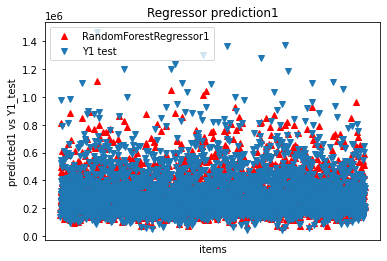

In [258]:
plt.figure()
plt.plot(prediction1, 'r^', label='RandomForestRegressor1')
plt.plot(Y1_test, 'v', label='Y1 test')
plt.tick_params(axis='x', which='both', bottom=False, top=False,
                labelbottom=False)
plt.ylabel('predicted1 vs Y1_test')
plt.xlabel('items')
plt.legend(loc="best")
plt.title('Regressor prediction1')

plt.show()

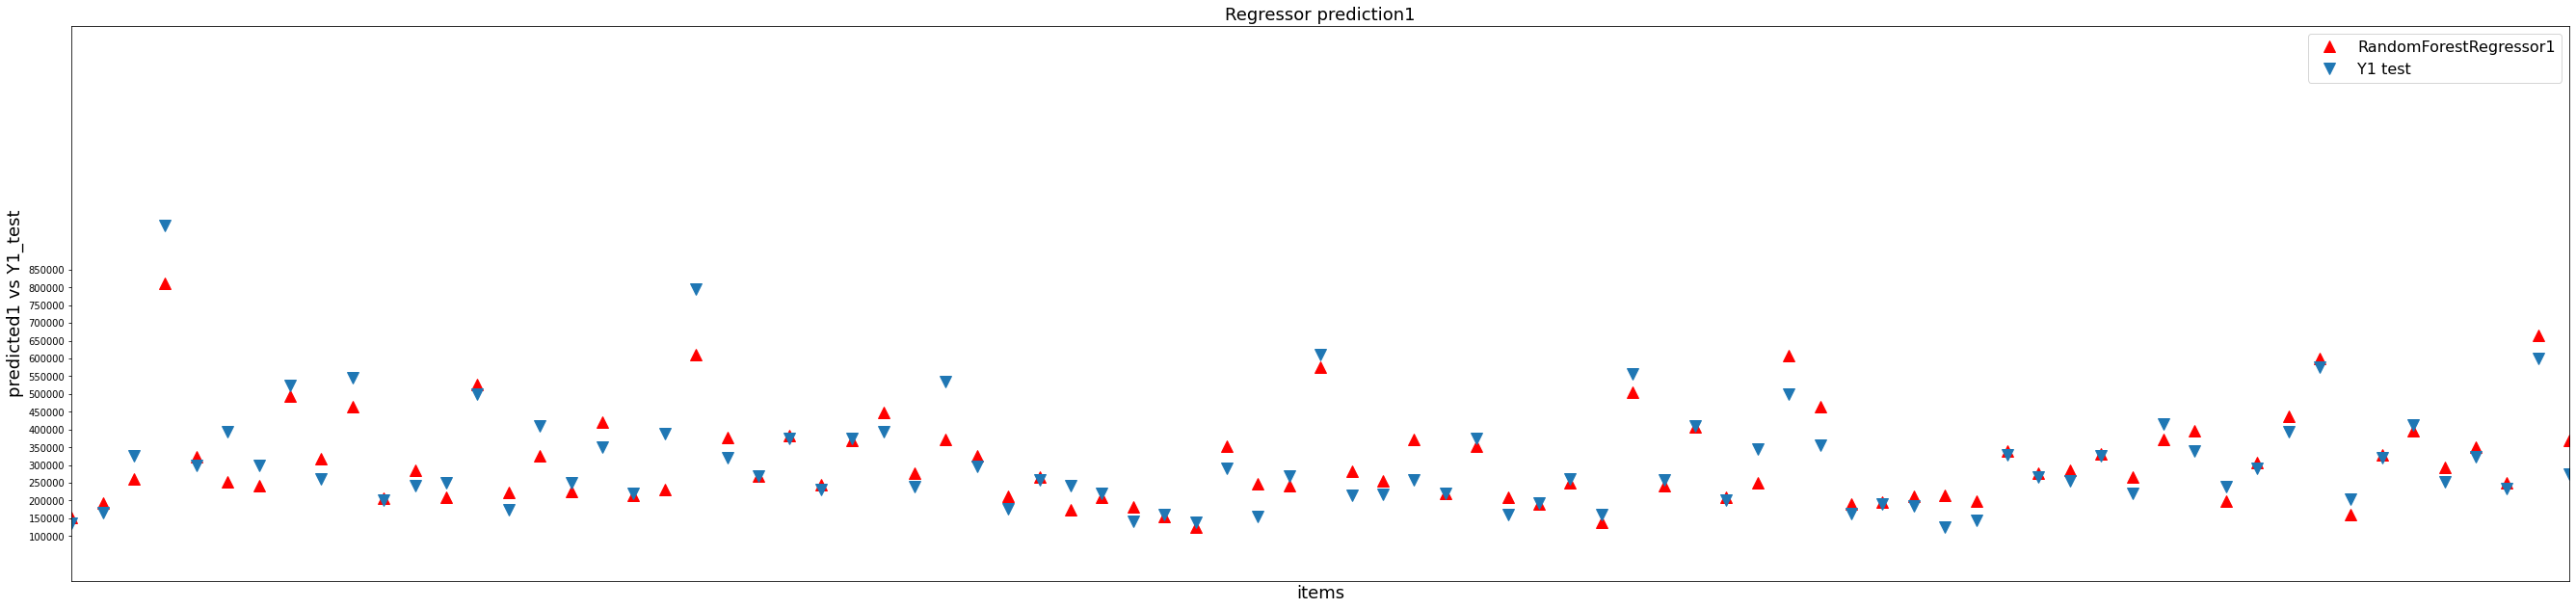

In [259]:
a= plt.figure()
axes= a.add_axes([0,0,6,2])#sequence of [left, bottom, width, height] quantities.
#axes= a.add_axes([0.2,0.2,8,8])
# adding axes
#x= np.arange(0,11)
#axes.plot(prediction, marker='*')
y = np.array([100000, 200000, 300000, 400000, 500000, 600000,700000,800000, 900000])
plt.yticks(np.arange(y.min(), y.max(), 50000))

axes.plot(prediction1, 'r^', label='RandomForestRegressor1',markersize=12)
axes.plot(Y1_test, 'v', label='Y1 test',markersize=12)
axes.set_xlim([0,80])
plt.tick_params(axis='x', which='both', bottom=False, top=False,
                labelbottom=False)
plt.ylabel('predicted1 vs Y1_test', fontsize=18)
plt.xlabel('items', fontsize=18)
plt.legend(loc="best",prop={'size': 16})
plt.title('Regressor prediction1', fontsize=18)

plt.show()

In [260]:
from sklearn import metrics
from sklearn.metrics import mean_squared_error

In [261]:
mean_squared_error1=metrics.mean_squared_error(prediction1,Y1_test)
mean_squared_error1
root_mse1_2=pow(mean_squared_error1,0.5)
root_mse1_2

75567.46308884647

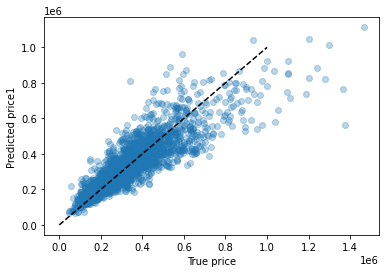

In [262]:
plt.scatter(Y1_test,prediction1,alpha=0.3)
plt.plot([0,1000000],[0,1000000],'--k')
plt.axis('tight')
plt.xlabel('True price')
plt.ylabel('Predicted price1')
plt.show()


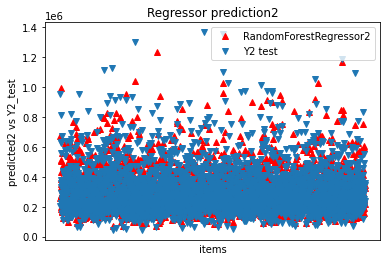

In [263]:
plt.figure()
plt.plot(prediction2, 'r^', label='RandomForestRegressor2')
plt.plot(Y2_test, 'v', label='Y2 test')
plt.tick_params(axis='x', which='both', bottom=False, top=False,
                labelbottom=False)
plt.ylabel('predicted2 vs Y2_test')
plt.xlabel('items')
plt.legend(loc="best")
plt.title('Regressor prediction2')

plt.show()


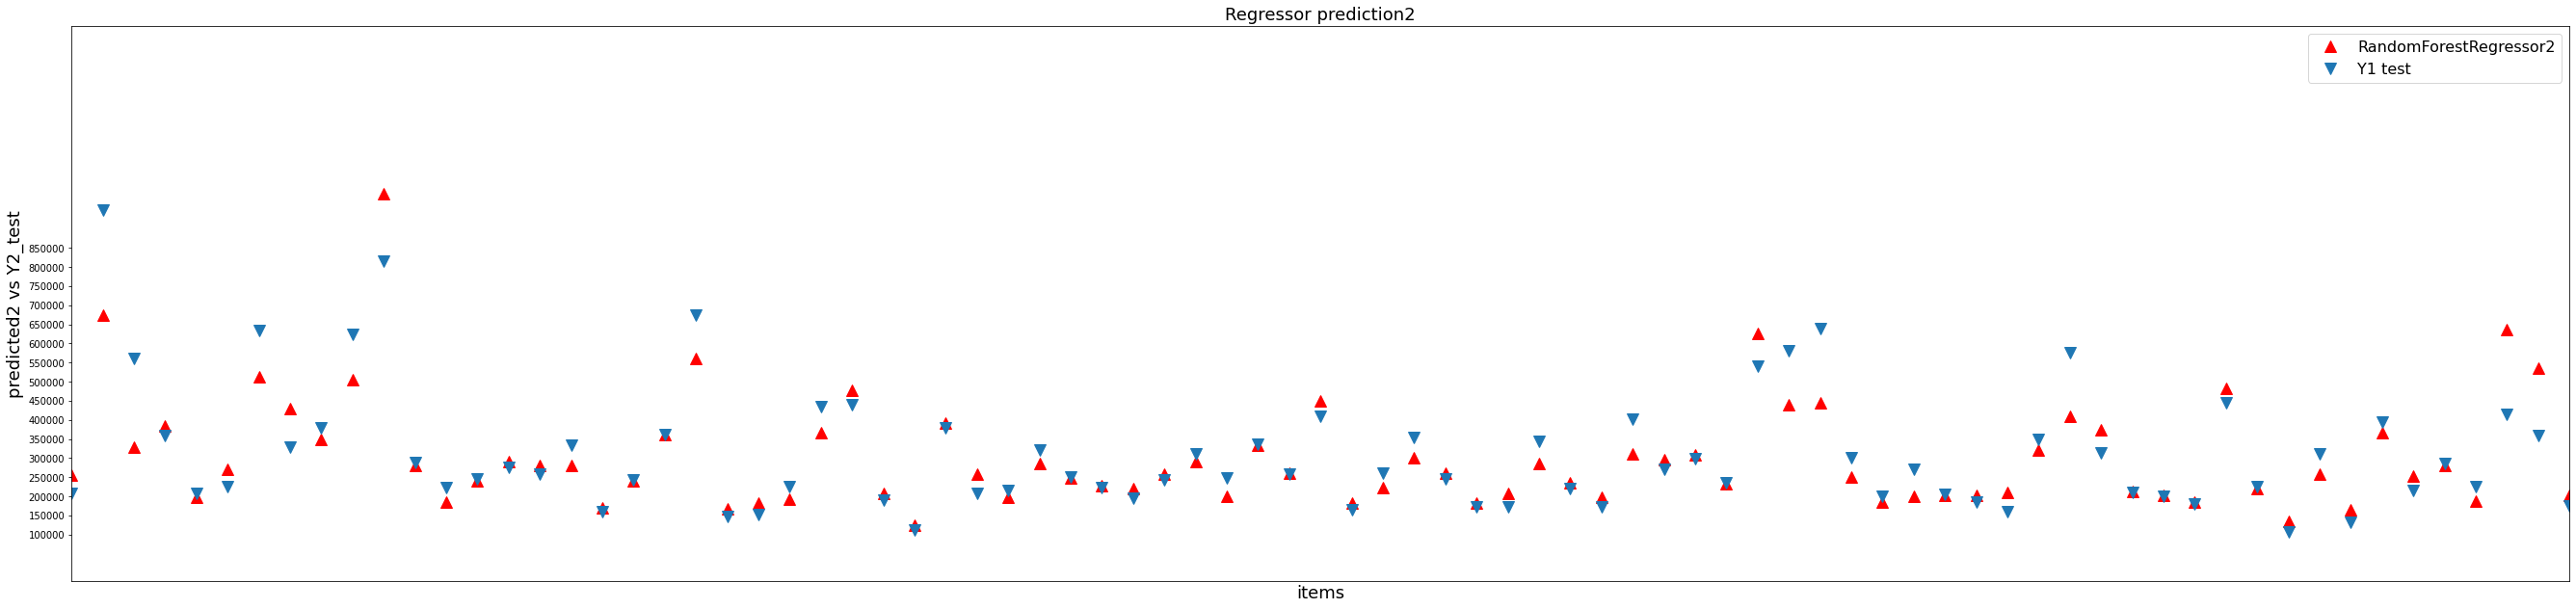

In [264]:
a= plt.figure()
axes= a.add_axes([0,0,6,2])#sequence of [left, bottom, width, height] quantities.
#axes= a.add_axes([0.2,0.2,8,8])
# adding axes
#x= np.arange(0,11)
#axes.plot(prediction, marker='*')
y = np.array([100000, 200000, 300000, 400000, 500000, 600000,700000,800000, 900000])
plt.yticks(np.arange(y.min(), y.max(), 50000))

axes.plot(prediction2, 'r^', label='RandomForestRegressor2',markersize=12)
axes.plot(Y2_test, 'v', label='Y1 test',markersize=12)
axes.set_xlim([0,80])
plt.tick_params(axis='x', which='both', bottom=False, top=False,
                labelbottom=False)
plt.ylabel('predicted2 vs Y2_test', fontsize=18)
plt.xlabel('items', fontsize=18)
plt.legend(loc="best",prop={'size': 16})
plt.title('Regressor prediction2', fontsize=18)

plt.show()

In [265]:
mean_squared_error2=metrics.mean_squared_error(prediction2,Y2_test)
mean_squared_error2
root_mse2_2=pow(mean_squared_error2,0.5)
root_mse2_2

70747.95392439877

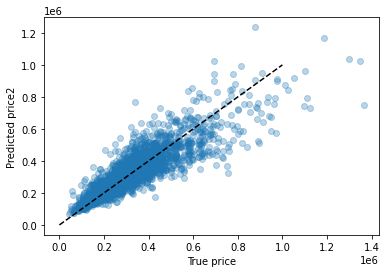

In [266]:
plt.scatter(Y2_test,prediction2,alpha=0.3)
plt.plot([0,1000000],[0,1000000],'--k')
plt.axis('tight')
plt.xlabel('True price')
plt.ylabel('Predicted price2')
plt.show()